<a href="https://colab.research.google.com/github/CyberIngeniero/Proyecto_Clustering_HDI/blob/master/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

$\color{forestgreen}{\underline{\text{Proyecto Nuevos Clusters para Vehículos}}}$

# Preliminares

## Librerias

In [93]:
# Librerias

#pip install pydotplus

import os
import shutil
import sys
import math

from google.colab import files    #files.upload()
from google.colab import drive    #drive.mount('/gdrive')

import pandas as pd

import numpy as np
np.set_printoptions(threshold=sys.maxsize)

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

from sklearn.impute import SimpleImputer

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, make_scorer
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials #Bayesiano

import pydotplus
from sklearn.tree import export_graphviz

import missingno as msno

from IPython.display import display, Markdown, Image

import warnings
warnings.filterwarnings("ignore")

## Funciones Ancilares

In [193]:
def df_norm(df):
    """
    :param df: df con variables a agrupar
    """

    cols = ['edad_bins', 'antiguedad_bins', 'sisgen_bins']
    enc = LabelEncoder()

    # Agrupacion de edad del asegurado
    df['edad_bins'] = pd.cut(x = df['edad'], 
                            bins = [-3, -2, -1, 18, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 100], 
                            labels = ['Extranjero', 'Empresa', '0 - 18', '19 - 25', '26 - 30', 
                                      '31 - 35', '36 - 40', '41 - 45', '46 - 50', '51 - 55', 
                                      '56 - 60', '61 - 65', '66 - 70', 'Mayor a 70'])

    # Agrupacion de Antiguedad de vehiculo
    df['antiguedad_bins'] = pd.cut(x = df['antiguedad_veh'], 
                                   bins = [-1, 0, 2, 4 ,8, 20],
                                   labels = ['0', '1 - 2', '3 - 4', '5 - 8', '9+'])

    # Agrupacion de sisgen
    df['sisgen_bins'] = pd.cut(x = df['sisgen_usar'], 
                               bins = [0, 0.85 , 0.91, 0.95 , 0.992, 
                                       1.08, 1.1  , 1.3, 1.5],
                               labels = ['S0.85', 'S0.87 - 0.91', 'S0.91 - 0.95', 
                                         'S0.95 - 0.97','S0.993 - 1.08', 'S1.1', 
                                         'S1.133 - 1.3', 'S1.333 - 1.5'])
    
    
    df.drop(columns = ['sisgen_usar', 'antiguedad_veh', 'edad'], axis = 1, inplace = True)

    for col in cols:
        colname = col + '_code'
        df[colname] = enc.fit_transform(df[col])
        df.drop(columns = [col], axis = 1, inplace = True)


# function for fitting trees of various depths on the training data using cross-validation
def run_cross_validation_on_trees(X, y, tree_depths, cv=5, scoring='accuracy'):
    """
    :param
    :param
    :param
    :param
    :param
    """
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    accuracy_scores = []
    for depth in tree_depths:
        tree_model = DecisionTreeClassifier(max_depth=depth)
        cv_scores = cross_val_score(tree_model, X, y, cv=cv, scoring=scoring)
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        accuracy_scores.append(tree_model.fit(X, y).score(X, y))
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    accuracy_scores = np.array(accuracy_scores)
    return cv_scores_mean, cv_scores_std, accuracy_scores
  

# function for plotting cross-validation results
def plot_cross_validation_on_trees(depths, cv_scores_mean, cv_scores_std, accuracy_scores, title):
    """
    :param
    :param
    :param
    :param
    :param
    """
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(depths, cv_scores_mean, '-o', label='mean cross-validation accuracy', alpha=0.9)
    ax.fill_between(depths, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2)
    ylim = plt.ylim()
    ax.plot(depths, accuracy_scores, '-*', label='train accuracy', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Tree depth', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(depths)
    ax.legend()


def confusion_to_df(mc):
    """
    :param mc: Matriz de Confusion
    :return: Matriz de Confusion como df
    """
    mc = mc.T
    df_mc = pd.concat([pd.Series(mc[0]), pd.Series(mc[1])], axis=1)
    df_mc.columns = ['Verdadero', 'Falso']
    df_mc.index = ['Verdadero', 'Falso']
    return df_mc


def metrics_report(model, X_train, y_train, X_test, y_test):
    # Fit Model
    y_train_pred = cross_val_predict(model, X_train, y_train, cv=10)
    y_train_proba = model.predict_proba(X_train)[:, 1]
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)[:, 1]


    print('----------------------------------------------------------------------------')
    print('Metrics Report Model ' + model.__class__.__name__ + ' -- Training Dataset')
    print('---------------------------------------------------------------------------- \n')

    # metrics
    print("\n METRICS RESUME MODEL")
    print("Precision: %f "%precision_score(y_train, y_train_pred))
    print("Recall: %f "%recall_score(y_train, y_train_pred))
    print("F1: %f"% f1_score(y_train, y_train_pred)) 
    print("AUC: ", roc_auc_score(y_train, y_train_pred))

    #matriz de confusion
    print("\n CONFUSION MATRIX")
    display(confusion_to_df(confusion_matrix(y_train, y_train_pred)))

    # Plot Confusion Matrix
    conf_mat = confusion_matrix(y_train, y_train_pred)
    labels = ['Class 0', 'Class 1']
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('Expected')
    plt.show()

    # Metrics Resume
    print("\n METRICS MODEL")
    display(pd.DataFrame(classification_report(y_train, y_train_pred, output_dict = True)))

    # grafica curva roc
    print("\n ROC CURVE MODEL")
    fpr, tpr, thresholds = roc_curve(y_train, y_train_proba)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='tomato')
    plt.plot(fpr, tpr, marker='.', lw=2)
    plt.title("ROC curve model " + model.__class__.__name__)
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.show();

    # Metrics Resume
    print("\n PRECISION-RECALL CURVE")
    disp = plot_precision_recall_curve(model, X_train, y_train)
    disp.ax_.set_title('2-class Precision-Recall curve: ' 'AP={0:0.2f}'.format(average_precision_score(y_train, y_train_pred)))
    plt.show();

    # Trade-off precision_recall
    print("\n TRADE-OFF PRECISION RECALL - TRAINING SET")
    prec, rec, tre = precision_recall_curve(y_train, y_train_proba, )
    plot_prec_recall_vs_tresh(prec, rec, tre)
    plt.show();

    print('\n \n ----------------------------------------------------------------------------')
    print('Metrics Report Model ' + model.__class__.__name__ + ' -- Testing Dataset')
    print('---------------------------------------------------------------------------- \n')

    # metrics
    print("\n METRICS RESUME MODEL")
    print("Precision: %f "%precision_score(y_test, y_test_pred))
    print("Recall: %f "%recall_score(y_test, y_test_pred))
    print("F1: %f"% f1_score(y_test, y_test_pred))
    print("AUC: ", roc_auc_score(y_test, y_test_pred))

    # matriz de confusion
    print("\n CONFUSION MATRIX")
    display(confusion_to_df(confusion_matrix(y_test, y_test_pred)))

    # Plot Confusion Matrix
    conf_mat = confusion_matrix(y_test, y_test_pred)
    labels = ['Class 0', 'Class 1']
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('Expected')
    plt.show()

    # Metrics Resume
    print("\n METRICS MODEL")
    display(pd.DataFrame(classification_report(y_test, y_test_pred, output_dict = True)))

    # grafica curva roc
    print("\n ROC CURVE MODEL")
    fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='tomato')
    plt.plot(fpr, tpr, marker='.', lw=2)
    plt.title("ROC curve model " + model.__class__.__name__)
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.show();

    # Metrics Resume
    print("\n PRECISION-RECALL CURVE")
    disp = plot_precision_recall_curve(model, X_test, y_test)
    disp.ax_.set_title('2-class Precision-Recall curve: ' 'AP={0:0.2f}'.format(average_precision_score(y_test, y_test_pred)))
    plt.show();

    # Trade-off precision_recall
    print("\n TRADE-OFF PRECISION RECALL - TESTING SET")
    prec, rec, tre = precision_recall_curve(y_test, y_test_proba, )
    plot_prec_recall_vs_tresh(prec, rec, tre)
    plt.show();


def tree_graph_to_png(tree, feature_names, png_file_to_save):
    tree_str = export_graphviz(tree, 
                               feature_names=feature_names, 
                               filled=True, out_file=None)
    graph = pydotplus.graph_from_dot_data(tree_str)  
    graph.write_png(png_file_to_save)


def acc_model(params):
    clf = DecisionTreeClassifier(**params)
    return cross_val_score(clf, X_train, y_train).mean()


def f(params):
    global best
    acc = acc_model(params)
    if acc > best:
        best = acc
    print ('new best:', best, params)
    return {'loss': -acc, 'status': STATUS_OK}    


def Performance(Model,Y,X):
    # Perforamnce of the model
    fpr, tpr, _ = roc_curve(Y, Model.predict_proba(X)[:,1])
    AUC  = auc(fpr, tpr)
    print ('the AUC is : %0.4f' %  AUC)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % AUC)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()     


def plot_prec_recall_vs_tresh(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
    plt.xlabel('Threshold')
    plt.legend(loc='center left')
    plt.ylim([0,1]) 


def metrics_comparative(model_list, auc_list, metrics_list, y_train_list, y_pred_list):
    # Grafica las metricas
    metrics = {}

    for index, model in enumerate(model_list):
        metrics.update({'Model_' +  model.__class__.__name__ + str(index + 1): [auc_list[index],
                                                                                accuracy_score(y_train_list[index], y_pred_list[index]).round(5),
                                                                                metrics_list[index]['weighted avg'].iloc[0].round(5),
                                                                                metrics_list[index]['weighted avg'].iloc[1].round(5),
                                                                                metrics_list[index]['weighted avg'].iloc[2].round(5)]})

    print("Metrics Comparison")
    errors_df = pd.DataFrame(metrics, index=['AUC', 'Accuracy', 'Presicion', 'Recall', 'F1'])
    display(errors_df.head())
    errors_df.plot(title='Models Metrics for Class Models', kind='barh',
                           figsize=(8, 6)).legend(bbox_to_anchor=(1.0, 0.5)); 


def canal_comparison(model, X, y):

    metrics = {}
    canal_list = {1 : 'DEALERS', 2 : 'DIRECTO', 3 : 'MASIVOS', 4 : 'CORREDOR'}

    for i in canal_list:
        X_canal = X[X['canal_code'] == i]
        y_canal = y[y.index.isin(X_canal.index)]
        y_pred_canal = cross_val_predict(model, X_canal, y_canal, cv=10)

        metrics.update({canal_list[i]: [roc_auc_score(y_canal, y_pred_canal),
                                        accuracy_score(y_canal, y_pred_canal).round(5),
                                        pd.DataFrame(classification_report(y_canal, y_pred_canal, output_dict = True))['weighted avg'].iloc[0].round(5),
                                        pd.DataFrame(classification_report(y_canal, y_pred_canal, output_dict = True))['weighted avg'].iloc[1].round(5),
                                        pd.DataFrame(classification_report(y_canal, y_pred_canal, output_dict = True))['weighted avg'].iloc[2].round(5)]})
        
    print("Metrics Comparison - Canales")
    errors_df = pd.DataFrame(metrics, index=['AUC', 'Accuracy', 'Presicion', 'Recall', 'F1'])
    display(errors_df.head())
    errors_df.plot(title='Models Metrics for Class Models - Canales', kind='barh',
                   figsize=(8, 6)).legend(bbox_to_anchor=(1.0, 0.5));    


def canal_report(model, canal, X_train, y_train, X_test, y_test):

    canal_list = {1 : 'DEALERS', 2 : 'DIRECTO', 3 : 'MASIVOS', 4 : 'CORREDOR'}

    X_train_canal = X_train[X_train['canal_code'] == canal]
    y_train_canal = y_train[y_train.index.isin(X_train_canal.index)]

    X_test_canal = X_test[X_test['canal_code'] == canal]
    y_test_canal = y_test[y_test.index.isin(X_test_canal.index)]

    print('----------------------------------------------------------------------------')
    print('CANAL ' + canal_list[canal])

    metrics_report(model, X_train_canal, y_train_canal, X_test_canal, y_test_canal)                                                

# Carga y Lectura de Registros

In [3]:
# Se crea directorio de trabajo
path = "/tmp/data_clusters"
os.mkdir(path)

In [4]:
# Montando Drive
drive.mount('/gdrive')

Mounted at /gdrive


In [5]:
# Copia del archivo a directorio local
!cp  /gdrive/My\ Drive/Proyecto_Nuevos_Clusters/Clustering_22_09_2020.csv /tmp/data_clusters

In [6]:
# Moviendo datos a entorno de trabajo
os.rename("/tmp/data_clusters/Clustering_22_09_2020.csv", "/tmp/data_clusters/Base_Clusters_MM.csv")

In [7]:
# Cambiando a directorio de trabajo
os.chdir(path)
print(os.getcwd())

/tmp/data_clusters


In [8]:
df = pd.read_csv("Base_Clusters_MM.csv", delimiter = ';', decimal=",")
df.columns = df.columns.str.lower()
df = df.rename(columns = {'sum([cantidad convertida final])':'cantidad_polizas',
                          'edad_final':'edad'})
df = df.drop(['edad_asegurado'], axis = 1) #version de edad asegurado en el cual se tiene junto extranjero a los 35 años

In [9]:
display(df.head())

rut_num  antiguedad_veh  ...  rc_ltv_precot  tasa_conversion
0  24855954.0               0  ...         0.9091          100,00%
1  16173686.0               0  ...         0.9421          100,00%
2  14183913.0               0  ...         0.8486          100,00%
3  23418340.0               0  ...         0.9338          100,00%
4  18885743.0               0  ...         1.1170          100,00%

[5 rows x 20 columns]

# Data Treatment

## Información General

In [10]:
# Información de la data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 983239 entries, 0 to 983238
Data columns (total 20 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   rut_num                          983207 non-null  float64
 1   antiguedad_veh                   983239 non-null  int64  
 2   dia_precot                       983239 non-null  int64  
 3   prima_neta_deducible_anualizada  983233 non-null  float64
 4   sisgen_usar                      983239 non-null  float64
 5   mod_tasacion_fiscal              978799 non-null  float64
 6   precot_veh_modelo_id             983239 non-null  int64  
 7   canal_producto                   983239 non-null  object 
 8   precot_veh_tipo_id               983239 non-null  int64  
 9   precot_veh_tipo                  983239 non-null  object 
 10  precot_veh_uso                   983239 non-null  object 
 11  precot_veh_uso_id                983239 non-null  int64  
 12  nu

## Analisis de Datos Perdidos

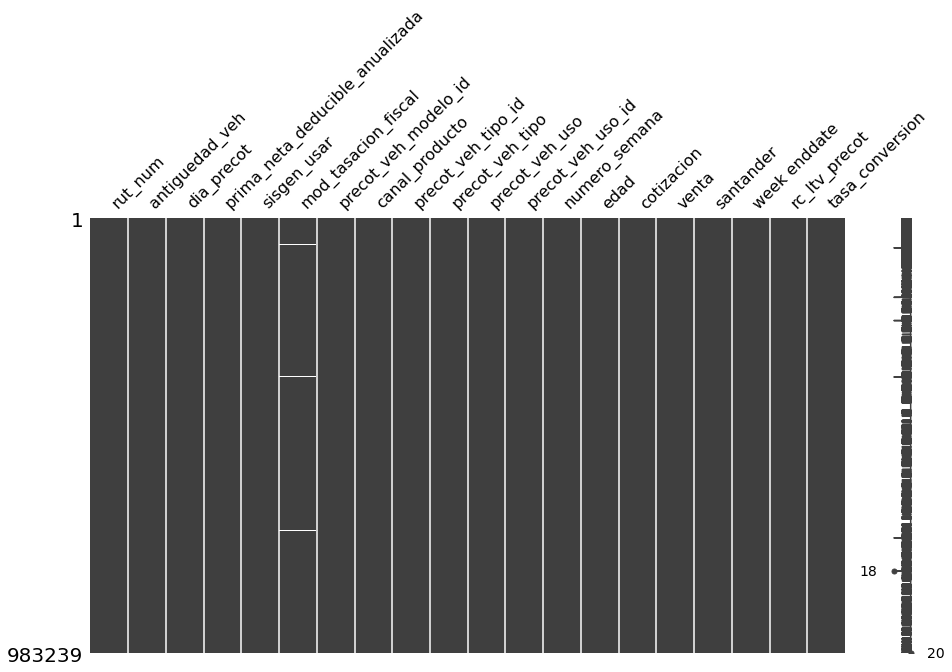

In [11]:
# Analisis de Datos Perdidos
msno.matrix(df, figsize=(15,8));

In [12]:
# Conteo de Registros NUlos
print('Valores Nulos por Columna \n')
df.isnull().sum(axis = 0)

Valores Nulos por Columna 



rut_num                              32
antiguedad_veh                        0
dia_precot                            0
prima_neta_deducible_anualizada       6
sisgen_usar                           0
mod_tasacion_fiscal                4440
precot_veh_modelo_id                  0
canal_producto                        0
precot_veh_tipo_id                    0
precot_veh_tipo                       0
precot_veh_uso                        0
precot_veh_uso_id                     0
numero_semana                         0
edad                                  0
cotizacion                            0
venta                                 0
santander                             0
week enddate                          0
rc_ltv_precot                         7
tasa_conversion                       0
dtype: int64

__COMENTARIOS__
 - Para favorecer el análsis, los registros nulos será imputados por la media de cada columna.

## Imputación de Missing data y Ajustes de Variables

In [13]:
# Ajuste de Variables

# Ajuste de varibale rut_num
#df.dropna(axis = 0, subset=['rut_num'], inplace = True) #registros con rut vacio
df['rut_num'] = df['rut_num'].astype('object')

# Ajuste de varibale prima_neta_deducible_anualizada
df['prima_neta_deducible_anualizada'].fillna(round(df['prima_neta_deducible_anualizada'].mean(), 2), inplace = True)

# Ajuste de varibale rc_ltv_precot
df['rc_ltv_precot'].fillna(round(df['rc_ltv_precot'].mean(), 2), inplace = True)

# Ajuste de varibale precot_veh_modelo_id
df['precot_veh_modelo_id'] = df['precot_veh_modelo_id'].astype('object')

# Ajuste de varibale santander
df['santander'] = df['santander'].astype('int32')
df['santander'] = df['santander'].astype('object')

# Ajuste de varibale numero_semana
df['numero_semana'] = df['numero_semana'].fillna(value = '0').astype('int32')

# Ajuste de varibale tasacion fiscal
df['mod_tasacion_fiscal'] = df['mod_tasacion_fiscal'].fillna(value = '11').astype('int32')

# Ajuste de Variable Edad
df['edad'].replace({'Empresa' : '-1', 
                    'Extranjero' : '-2'}, 
                   inplace = True)

df['edad'] = df['edad'].astype('int32')

df['edad'].fillna(value = int(df['edad'].mean()),
                  inplace = True)               


# Ajuste de Variable antiguedad_veh
df['antiguedad_veh'] = df['antiguedad_veh'].astype('int32')

# Ajuste de varibale precot_veh_modelo_id
df['precot_veh_uso'].replace({'Particular (Vehículos de uso personal y/o familiar destinado al transporte sin fines de lucro)' : 'Particular', 
                              'Otros usos comerciales distintos de transporte de pasajero y/o carga' : 'Otros Usos', 
                              'Transporte Pasajeros' : 'Transporte',
                              'Taxi Básico' : 'Taxi',
                              'Vehículo de Reparto' : 'Reparto'}, inplace=True)

# Ajuste de varibale santander
df['venta'] = df['venta'].astype('object')

## Análisis Univariado

In [14]:
df.describe()

antiguedad_veh     dia_precot  ...     cotizacion  rc_ltv_precot
count   983239.000000  983239.000000  ...  983239.000000  983239.000000
mean         2.911086      15.842948  ...       1.006942       0.875026
std          3.331797       8.657400  ...       0.084584       0.177648
min          0.000000       1.000000  ...       1.000000     -73.400000
25%          0.000000       9.000000  ...       1.000000       0.805600
50%          2.000000      16.000000  ...       1.000000       0.888600
75%          5.000000      23.000000  ...       1.000000       0.946100
max         19.000000      31.000000  ...       7.000000      78.900000

[8 rows x 11 columns]

## Análisis Univariado Gráfico

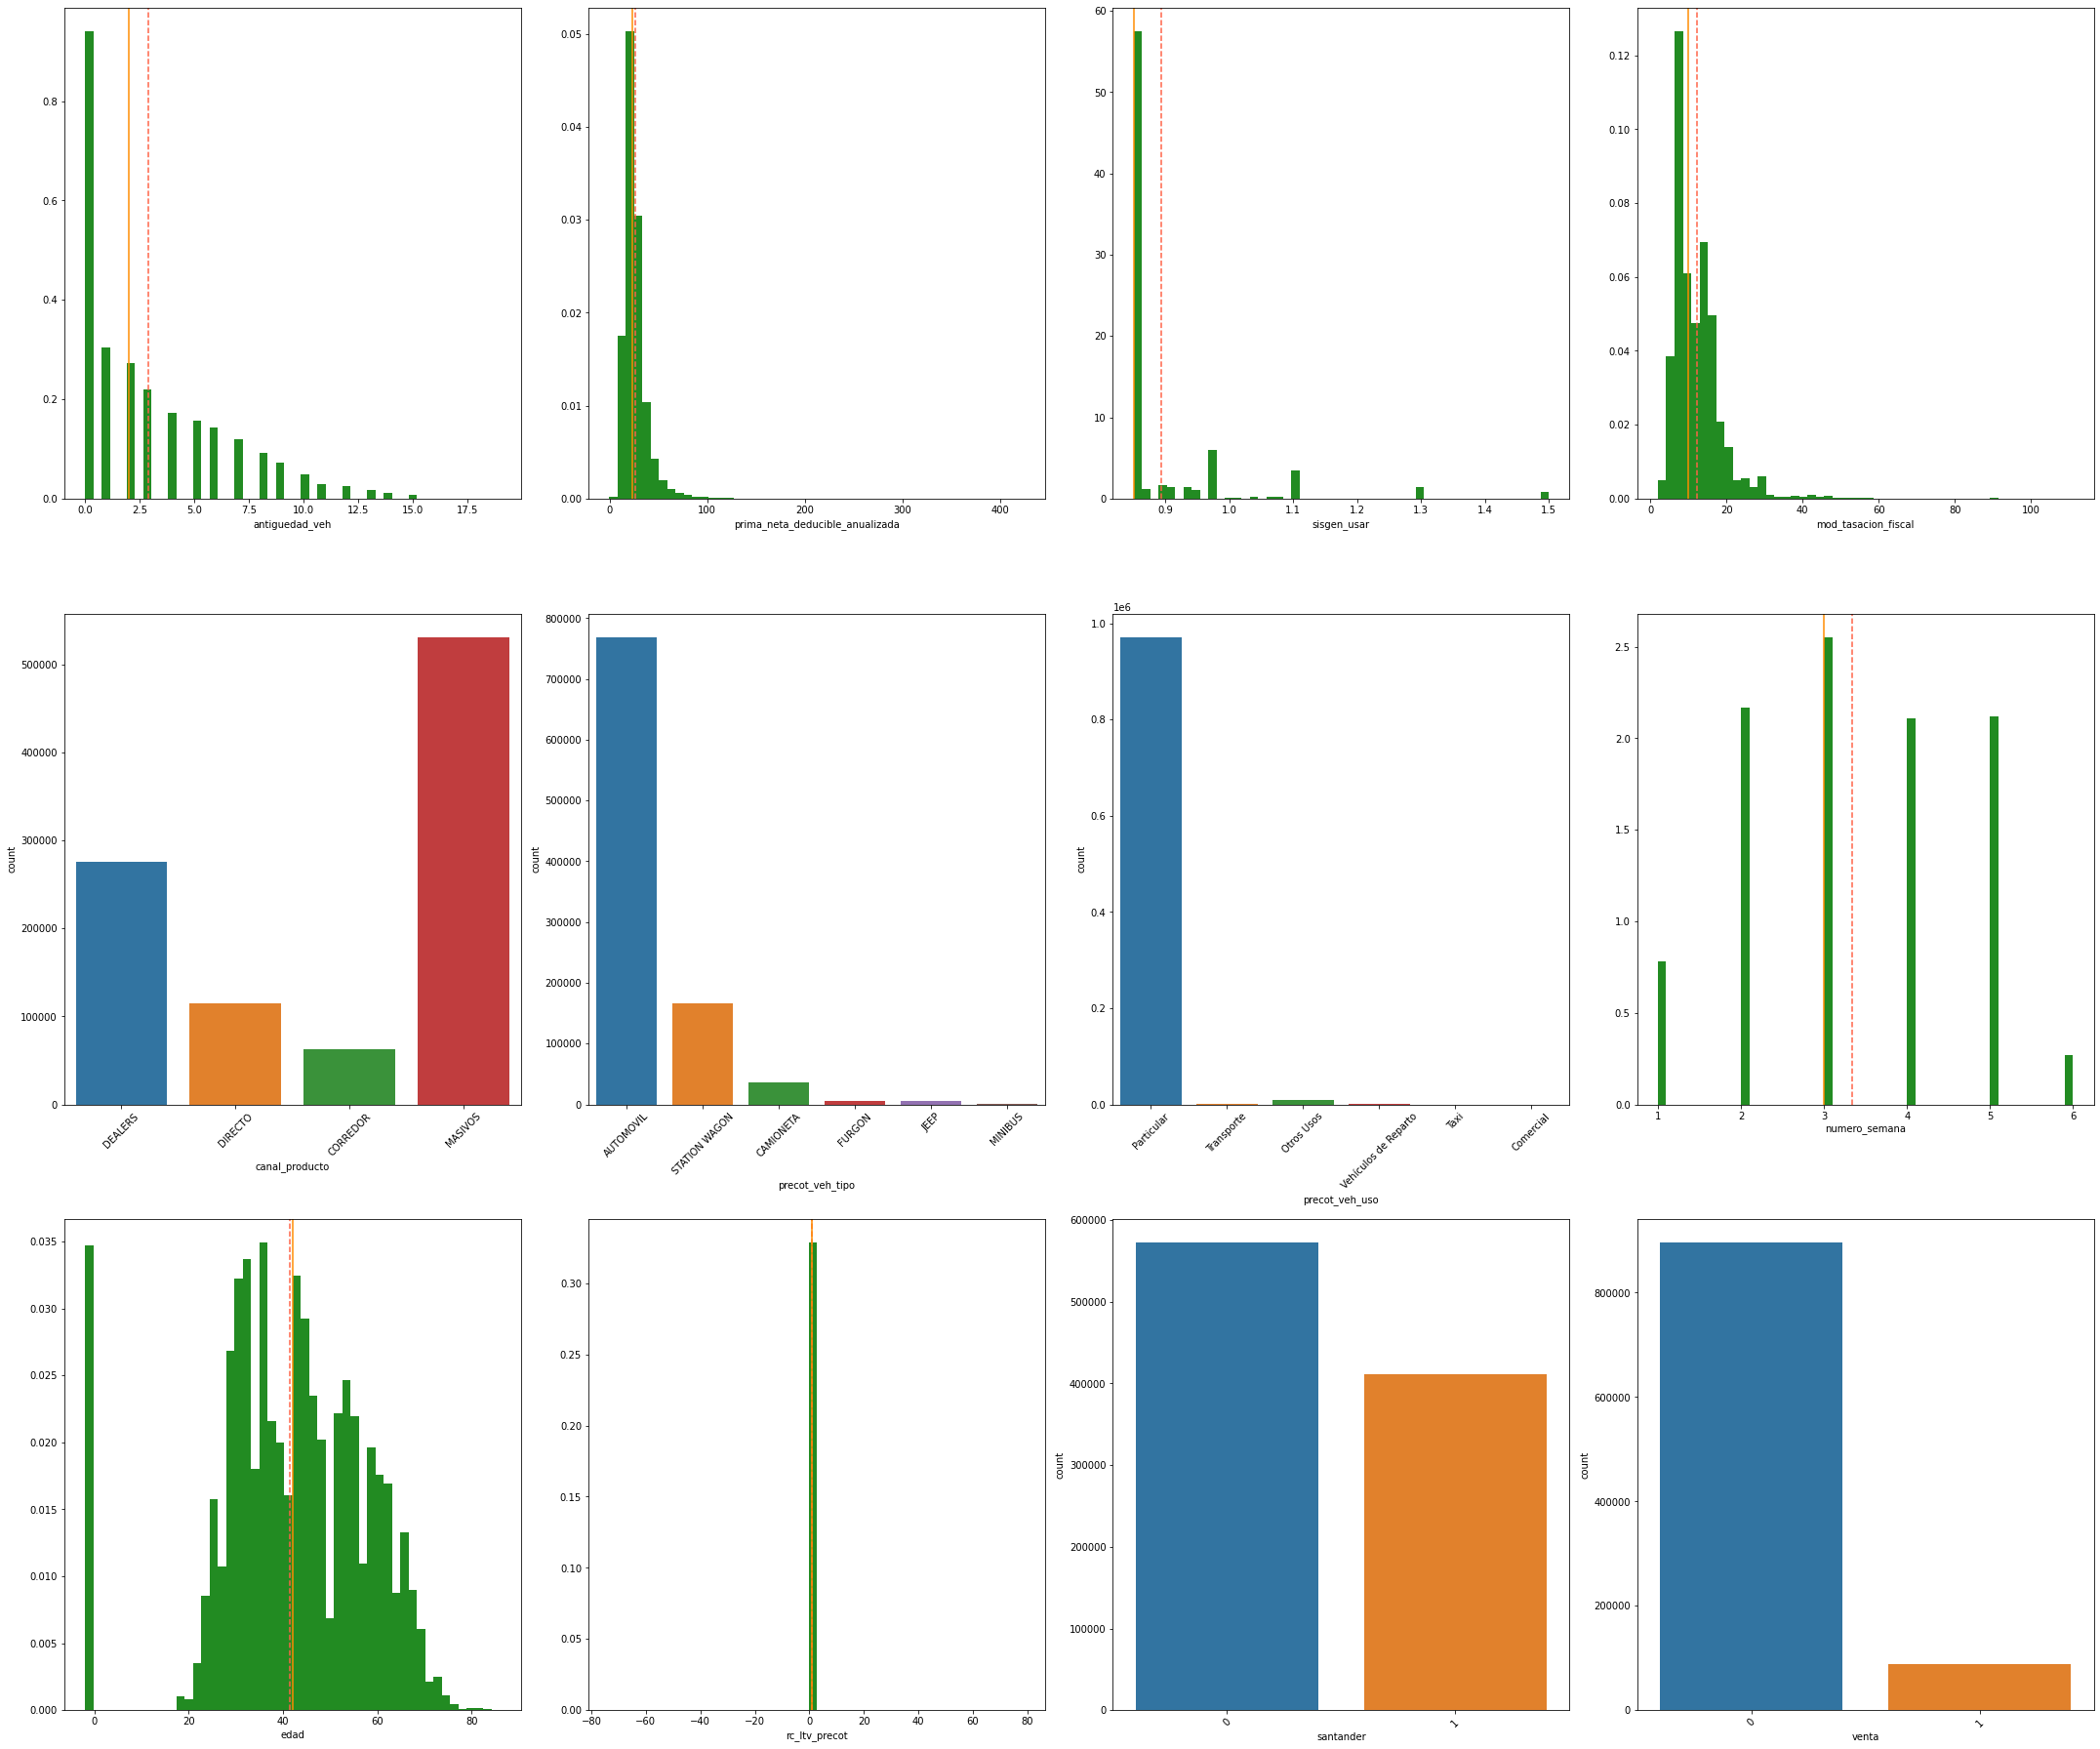

In [19]:
# Analisis Univariado
variables = ['antiguedad_veh', 'prima_neta_deducible_anualizada', 'sisgen_usar',
             'mod_tasacion_fiscal', 'canal_producto', 'precot_veh_tipo', 
             'precot_veh_uso', 'numero_semana', 'edad', 'rc_ltv_precot', 'santander', 'venta']

i = 0
m = 0

fig, axs = plt.subplots(3, 4, constrained_layout=True, figsize = (30,25))

for var in variables:
    if df[var].dtype == 'O':
        sns.countplot(var, data=df, ax = axs[m,i])
        plt.setp(axs[m,i].xaxis.get_majorticklabels(), rotation=45)

        i += 1

        if i % 4 == 0:
            m += 1
            i = 0
    else:
        axs[m,i].hist(df[var], density=True, color="forestgreen", bins=50)
        axs[m,i].axvline(df[var].mean(), color='tomato', linestyle='--', label='mean')
        axs[m,i].axvline(df[var].median(), color='darkorange', linestyle='-', label='median')
        #axs[m,i].set_xlim([df[var].min() - 1, df[var].max() + 1])
        #axs[m,i-1].set_title(var)
        axs[m,i].set_xlabel(var);
        plt.xticks(rotation=45)

        i += 1

        if i % 4 == 0:
            m += 1
            i = 0

#axs[2, 3].remove()             

fig.tight_layout()
plt.show();  

__Comentarios__
- Se sugiere realizar agrupaciones en las variables `edad` y `antiguedad_veh`.
- La variable objetivo `venta` se muestra desbalanceada, lo que será tratado más adelante.

## Grouping Data

In [20]:
# Agrupacion de edad del asegurado
df['edad_bins'] = pd.cut(x = df['edad'], 
                        bins = [-3, -2, -1, 18, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 100], 
                        labels = ['Extranjero', 'Empresa', '0 - 18', '19 - 25', '26 - 30', 
                                '31 - 35', '36 - 40', '41 - 45', '46 - 50', '51 - 55', 
                                '56 - 60', '61 - 65', '66 - 70', 'Mayor a 70'])

# Agrupacion de Antiguedad de vehiculo
df['antiguedad_bins'] = pd.cut(x = df['antiguedad_veh'], 
                            bins = [-1, 0, 2, 4 ,8, 20],
                            labels = ['0', '1 - 2', '3 - 4', '5 - 8', '9+'])

# Agrupacion de sisgen
df['sisgen_bins'] = pd.cut(x = df['sisgen_usar'], 
                        bins = [0, 0.85 , 0.91, 0.95 , 0.992, 1.08, 1.1  , 1.3, 1.5],
                        labels = ['S0.85', 'S0.87 - 0.91', 'S0.91 - 0.95', 'S0.95 - 0.97','S0.993 - 1.08', 'S1.1', 'S1.133 - 1.3', 'S1.333 - 1.5'])                                    

__Comentario__
- Para agrupar las variables `edad`, `antiguedad_veh` Y  `sisgen_usar` se utilizo como criterio las agrupaciones existentes hoy en día en el modelo de vehiculos vigente.

### Grouping Inspection

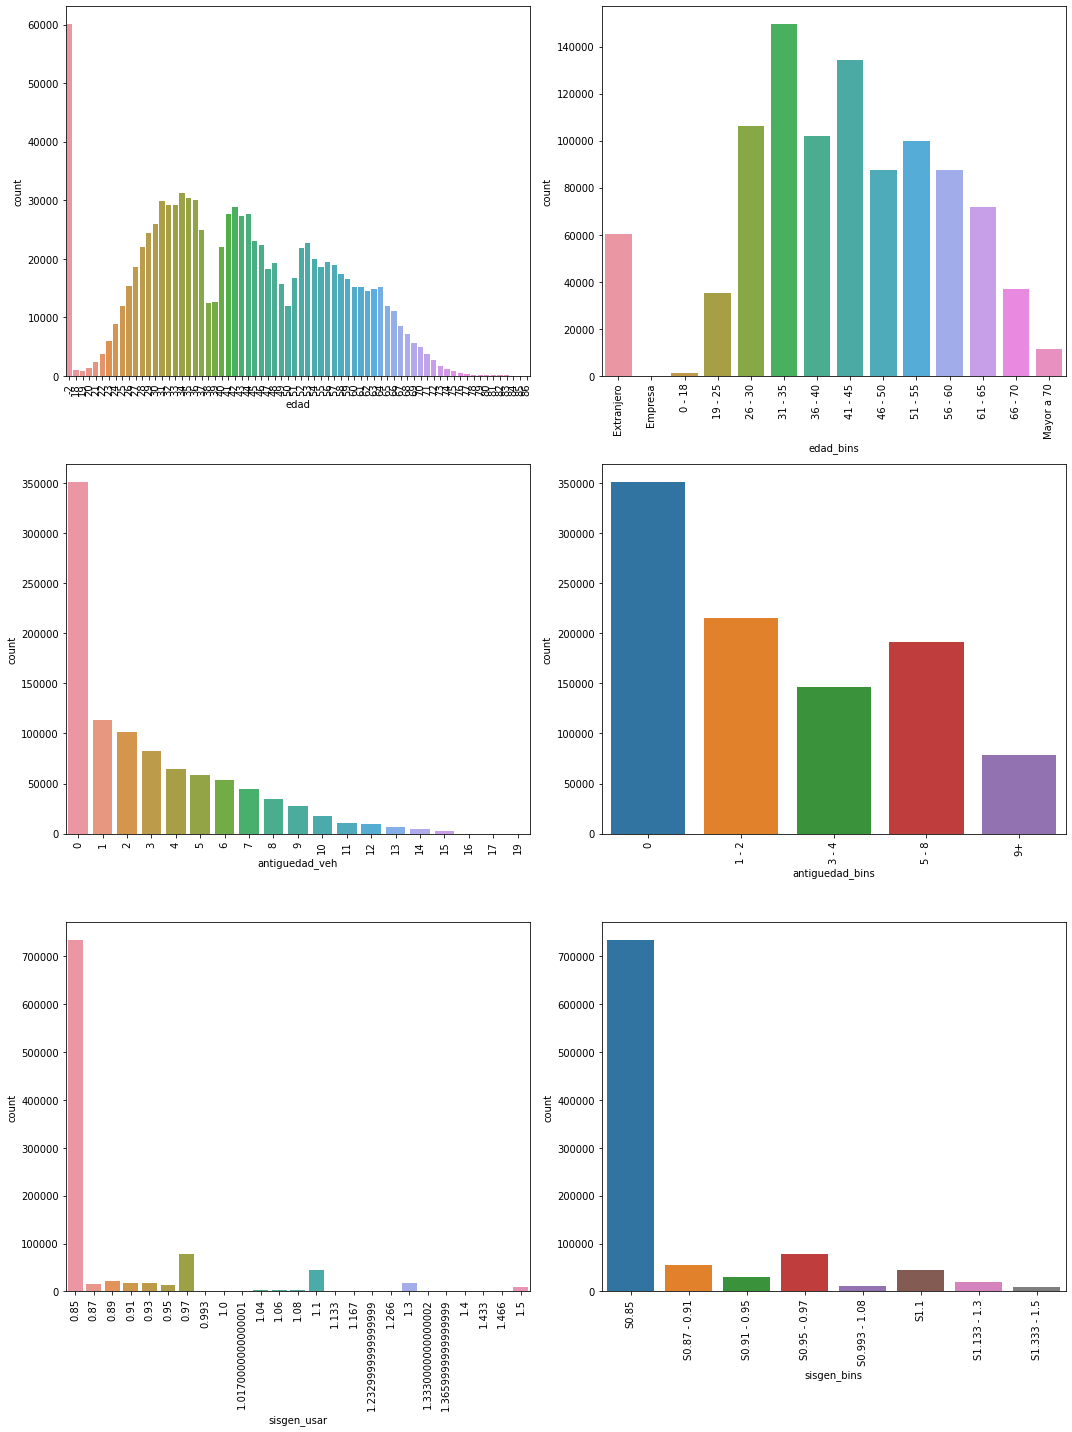

In [21]:
variables = ['edad', 'edad_bins', 'antiguedad_veh', 'antiguedad_bins', 'sisgen_usar', 'sisgen_bins']

i = 0
m = 0

fig, axs = plt.subplots(3, 2, constrained_layout=True, figsize = (15,20))

for var in variables:
    sns.countplot(var, data=df, ax = axs[m,i])
    plt.setp(axs[m,i].xaxis.get_majorticklabels(), rotation=90)

    i += 1

    if i % 2 == 0:
        m += 1
        i = 0        

fig.tight_layout()
plt.show();  

## Análisis Variable Objetivo: `venta`

In [22]:
# Porcentaje de 0 y 1 respectivamente
df['venta'].value_counts()

0    895578
1     87661
Name: venta, dtype: int64

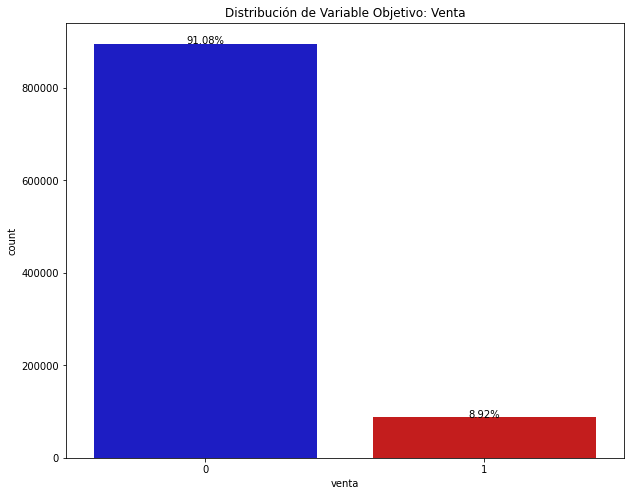

In [23]:
# Graficamente
total = float(len(df))

plt.figure(figsize=(10,8))
ax = sns.countplot('venta', data = df, 
                   palette = ["#0101DF", "#DF0101"]);
plt.title('Distribución de Variable Objetivo: Venta')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            str(('{:1.2f}'.format((height/total)*100))) + '%',
            ha="center") 

### Variable Objetivo Filtrando Santander

In [60]:
# se filtran registros que no corresponden a santander
df_filter = df[df['santander'] == 0]

print('data original: ', df.shape)
print('data sin santander: ', df_filter.shape)

data original:  (983239, 23)
data sin santander:  (572204, 23)


In [61]:
# Porcentaje de 0 y 1 respectivamente
df_filter['venta'].value_counts()

0    488935
1     83269
Name: venta, dtype: int64

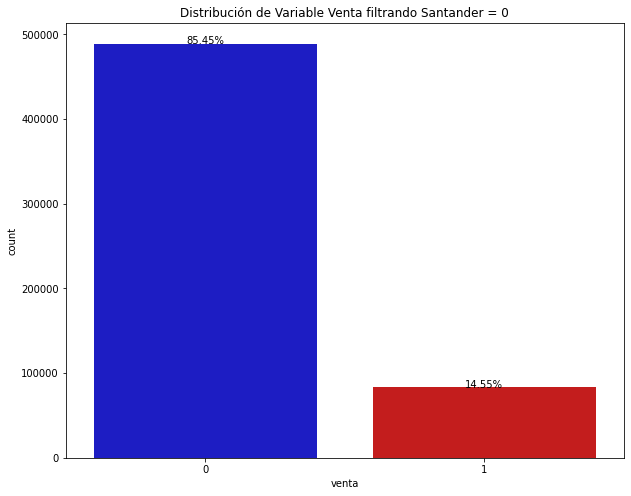

In [62]:
# Graficamente
total = float(len(df_filter))

plt.figure(figsize=(10,8))
ax = sns.countplot('venta', data = df_filter, 
                   palette = ["#0101DF", "#DF0101"]);
plt.title('Distribución de Variable Venta filtrando Santander = 0')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            str(('{:1.2f}'.format((height/total)*100))) + '%',
            ha="center") 

# Análisis de Outliers

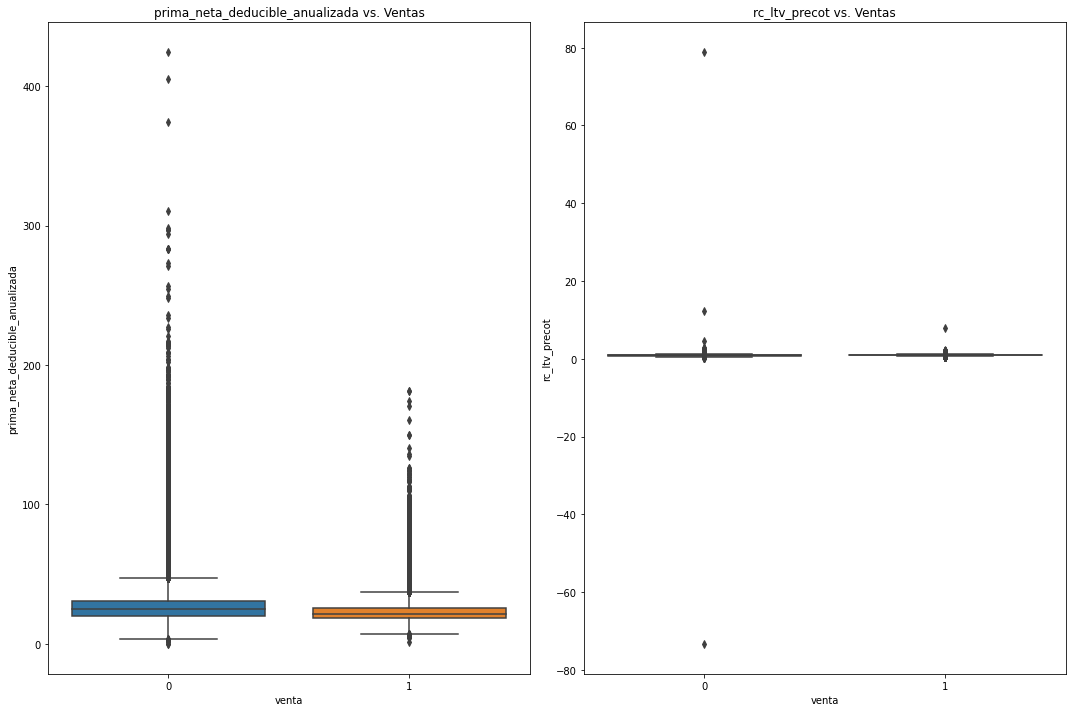

In [63]:
# Dispersion de variables y detección de Outliers: Boxplot
variables = ['prima_neta_deducible_anualizada', 'rc_ltv_precot']

i = 0

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize = (15,10))

for var in variables:
    sns.boxplot(x = 'venta', 
                y = var, 
                data = df_filter,
                ax = axs[i])
    axs[i].set_title(var + ' vs. Ventas')

    i += 1     

fig.tight_layout()
plt.show();

## Tratamiento de Outliers

In [64]:
# # Deteccion y Eliminación de Outliers por Zscore
# variables = ['prima_neta_deducible_anualizada', 'rc_ltv_precot', 'mod_tasacion_fiscal']

# threshold = 3  #3 desviaciones standar

# for var in variables:
#     z = np.abs(stats.zscore(df_filter[var]))
#     outliers_index = np.where(z > threshold)
#     df_filter = df_filter.loc[~df_filter.index.isin(outliers_index[0])]

In [65]:
# Deteccion y Eliminación de Outliers por IQR
variables = ['prima_neta_deducible_anualizada', 'rc_ltv_precot']

for var in variables:
    Q1 = df_filter[var].quantile(0.25)
    Q3 = df_filter[var].quantile(0.75)
    IQR = Q3 - Q1
    outlier_indices = df_filter[(df_filter[var] < Q1 - 1.5 * IQR) | (df_filter[var] > Q3 + 1.5 * IQR)].index
    df_filter = df_filter.loc[~df_filter.index.isin(outlier_indices)]

print('data sin santander ni outliers: ', df_filter.shape)    

data sin santander ni outliers:  (528770, 23)


## Inspección de Variables tratadas

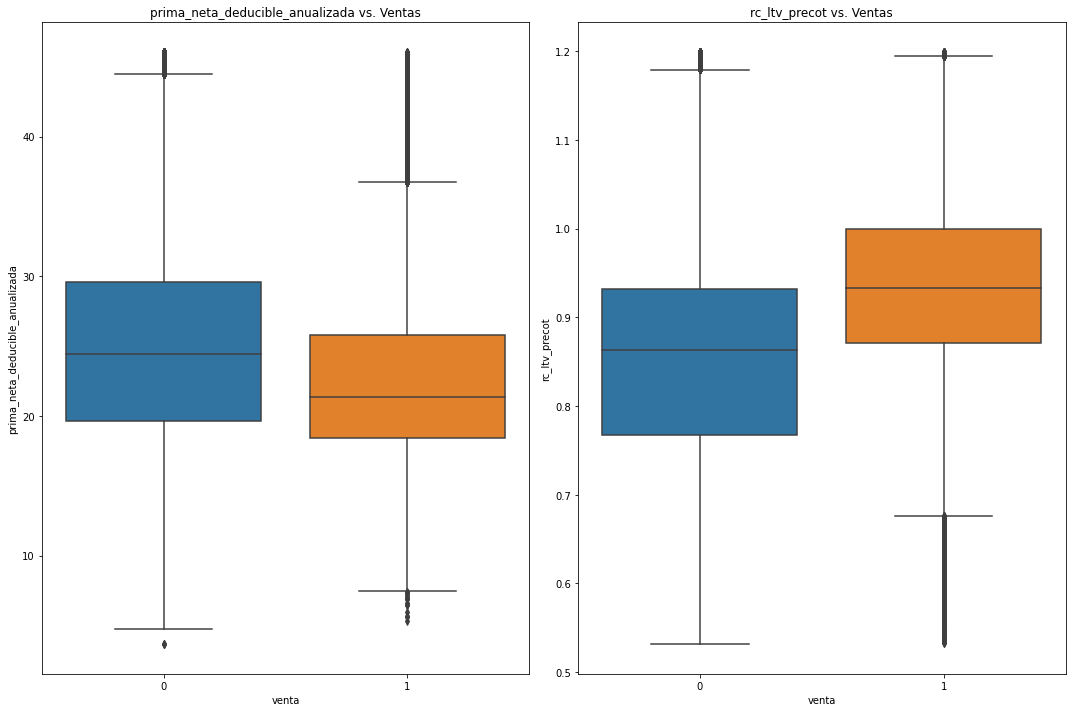

In [66]:
# Dispersion de variables sin outliers
variables = ['prima_neta_deducible_anualizada', 'rc_ltv_precot']

i = 0

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize = (15,10))

for var in variables:
    sns.boxplot(x = 'venta', 
                y = var, 
                data = df_filter,
                ax = axs[i])
    axs[i].set_title(var + ' vs. Ventas')

    i += 1     

fig.tight_layout()
plt.show();

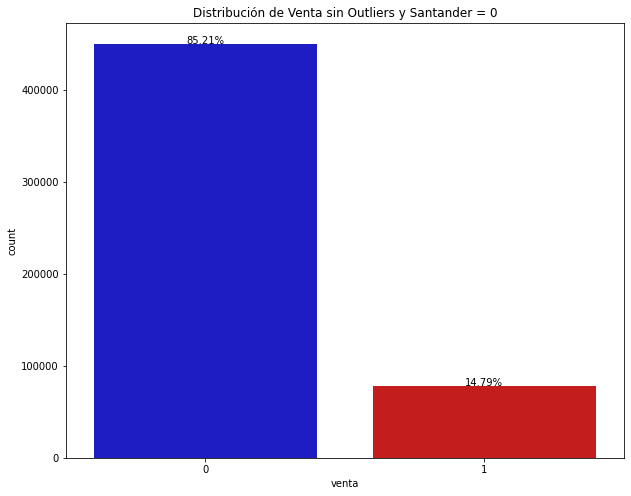

In [67]:
# Graficamente
total = float(len(df_filter))

plt.figure(figsize=(10,8))
ax = sns.countplot('venta', data = df_filter, 
                   palette = ["#0101DF", "#DF0101"]);
plt.title('Distribución de Venta sin Outliers y Santander = 0')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            str(('{:1.2f}'.format((height/total)*100))) + '%',
            ha="center") 

# Análisis de Correlaciones

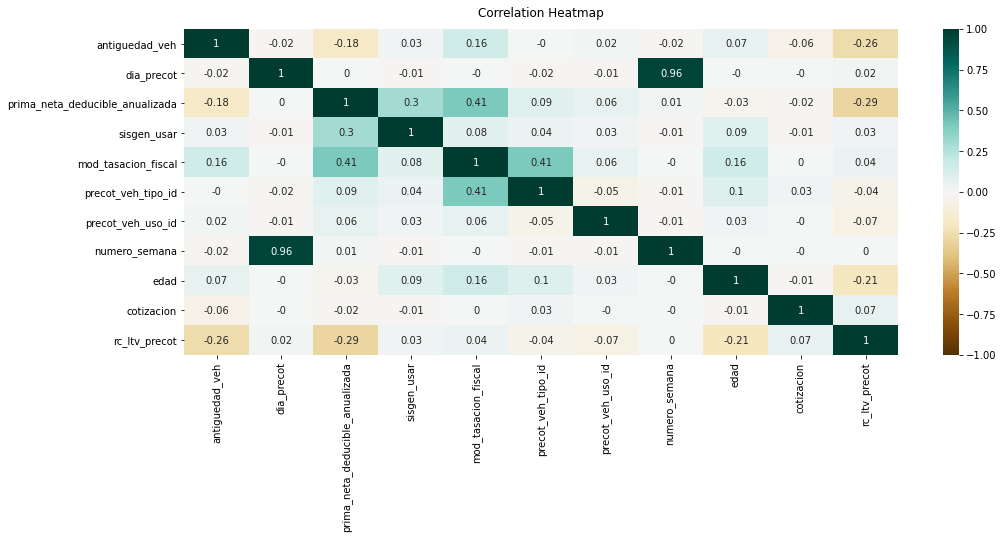

In [68]:
# Analisis de Correlación
plt.figure(figsize=(16, 6))
ax = sns.heatmap(df_filter.corr().round(2), annot=True, vmin=-1, vmax=1, cmap= 'BrBG')
ax.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

# Categorical Encoding

In [69]:
# Codificando Canal de Venta
canal_dict = {'DEALERS' : 1,
              'DIRECTO' : 2,
              'MASIVOS' : 3,
              'CORREDOR' : 4}

df_filter['canal_code'] = df_filter.canal_producto.map(canal_dict)
df_filter.drop(columns = ['canal_producto'], axis = 1, inplace = True)

In [70]:
cols = ['edad_bins', 'antiguedad_bins', 'sisgen_bins','precot_veh_modelo_id']

enc = LabelEncoder()

for col in cols:
        colname = col + '_code'
        df_filter[colname] = enc.fit_transform(df_filter[col])
        df_filter.drop(columns = [col], axis = 1, inplace = True)

# Copias de datos para Modelación

In [212]:
# Copia de registros a modelar
data_model_1 = df_filter.copy()
data_model_2 = df_filter.copy()
data_model_3 = df_filter.copy()
data_model_4 = df_filter.copy()
data_model_5 = df_filter.copy()

# Modelacion 1

## Filtro de variables a considerar

In [73]:
# Borrando variables que no se usaran
data_model_1.drop(columns = ['rut_num', 'antiguedad_veh', 'sisgen_usar',
                             'precot_veh_tipo', 'precot_veh_uso', 'numero_semana',
                             'edad', 'cotizacion', 'santander', 'week enddate', 
                             'tasa_conversion', 'edad'],
                  inplace = True)

# Vista previa de los registros a modelar
display(data_model_1)

dia_precot  ...  precot_veh_modelo_id_code
0               25  ...                        598
1               25  ...                        742
3                2  ...                        598
4               24  ...                        597
5               21  ...                        823
...            ...  ...                        ...
983230           8  ...                         66
983232          29  ...                        456
983233          30  ...                        276
983234          27  ...                        572
983235           7  ...                        182

[528770 rows x 12 columns]

## Data Split

In [74]:
# Genera data de train y test
data_train, data_test = train_test_split(data_model_1, test_size=.3, stratify = data_model_1.iloc[:,5], random_state = 0)
print('data_train: ', data_train.shape)
print('data_test: ', data_test.shape)

data_train:  (370139, 12)
data_test:  (158631, 12)


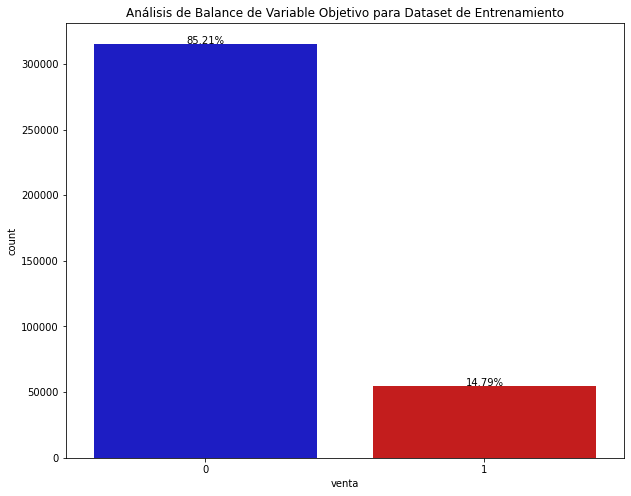

In [75]:
# Graficamente
total = float(len(data_train))

plt.figure(figsize=(10,8))
ax = sns.countplot('venta', data = data_train, 
                   palette = ["#0101DF", "#DF0101"]);
plt.title('Análisis de Balance de Variable Objetivo para Dataset de Entrenamiento')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            str(('{:1.2f}'.format((height/total)*100))) + '%',
            ha="center") 

## Control del Desbalance: Remuestreo

In [76]:
# Subsampling
data = data_train.sample(frac = 1) # Remuestro

target_1 = data.loc[data['venta'] == 1]
target_0 = data.loc[data['venta'] == 0][:len(target_1)]

sub_sample = pd.concat([target_1,target_0])
sub_sample = sub_sample.sample(frac = 1, random_state = 0).reset_index(drop = True)


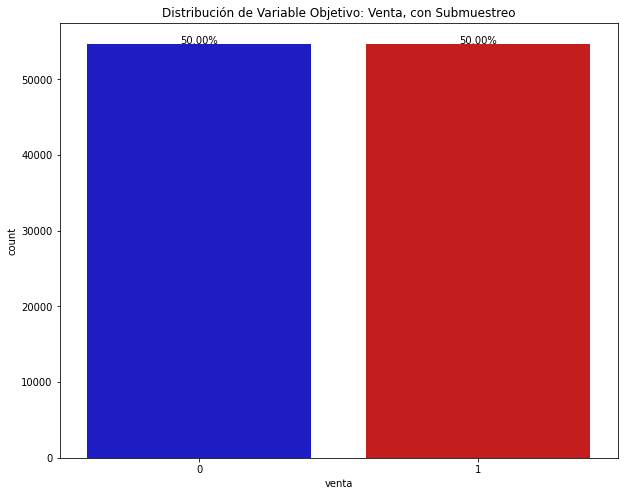

In [77]:
# Graficamente
total = float(len(sub_sample))

plt.figure(figsize=(10,8))
ax = sns.countplot('venta', data = sub_sample, 
                   palette = ["#0101DF", "#DF0101"]);
plt.title('Distribución de Variable Objetivo: Venta, con Submuestreo')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            str(('{:1.2f}'.format((height/total)*100))) + '%',
            ha="center") 

## Separando Vector Objetivo y Matriz de Diseño

In [78]:
# Separando X e y para train & test
X_train = sub_sample.drop(columns = ['venta'])
y_train = sub_sample['venta'].astype(int)

X_test = data_test.drop(columns = ['venta'])
y_test = data_test['venta'].astype(int)

## Optimización de Hiperparametros

In [79]:
#Fit Decision Tree Classifier
tree_params = {'criterion':['gini','entropy'],
               'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50]}

tree_grid = GridSearchCV(estimator = DecisionTreeClassifier(random_state = 16626),
                         param_grid = tree_params,
                         cv = 5,
                         n_jobs = -1,
                         scoring = 'f1_macro').fit(X_train, y_train)

print('Mejor score: ', tree_grid.best_score_)
print('Mejores Parametros: ', tree_grid.best_params_)

Mejor score:  0.7673233518740777
Mejores Parametros:  {'criterion': 'entropy', 'max_depth': 10}


## Grafico de Desempeño

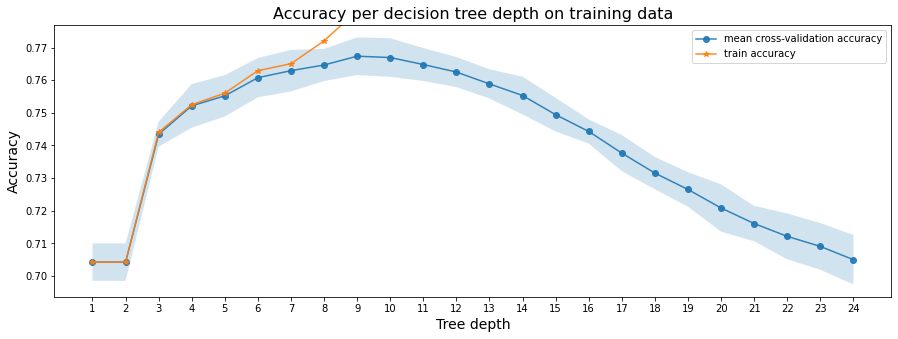

In [80]:
# fitting trees of depth 1 to 24
sm_tree_depths = range(1,25)
sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = run_cross_validation_on_trees(X_train, y_train, sm_tree_depths)

# plotting accuracy
plot_cross_validation_on_trees(sm_tree_depths, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores, 
                               'Accuracy per decision tree depth on training data')                             

In [81]:
# Best params
idx_max = sm_cv_scores_mean.argmax()
sm_best_tree_depth = sm_tree_depths[idx_max]
sm_best_tree_cv_score = sm_cv_scores_mean[idx_max]
sm_best_tree_cv_score_std = sm_cv_scores_std[idx_max]

print('The depth-{} tree achieves the best mean cross-validation accuracy {} +/- {}% on training dataset'.format(
      sm_best_tree_depth, round(sm_best_tree_cv_score*100,5), round(sm_best_tree_cv_score_std*100, 5)))

The depth-9 tree achieves the best mean cross-validation accuracy 76.73397 +/- 0.28856% on training dataset


## Ajuste y Predicciones del modelo

In [82]:
dec_tree = DecisionTreeClassifier(criterion = tree_grid.best_params_['criterion'],
                                  max_depth = tree_grid.best_params_['max_depth'],random_state = 16626).fit(X_train, y_train)  

# Train Predict
y_train_pred = cross_val_predict(dec_tree, X_train, y_train, cv=10)
y_train_proba = dec_tree.predict_proba(X_train)

# Test Predict
y_test_pred = dec_tree.predict(X_test)
y_test_proba = dec_tree.predict_proba(X_test)

## Features Importances

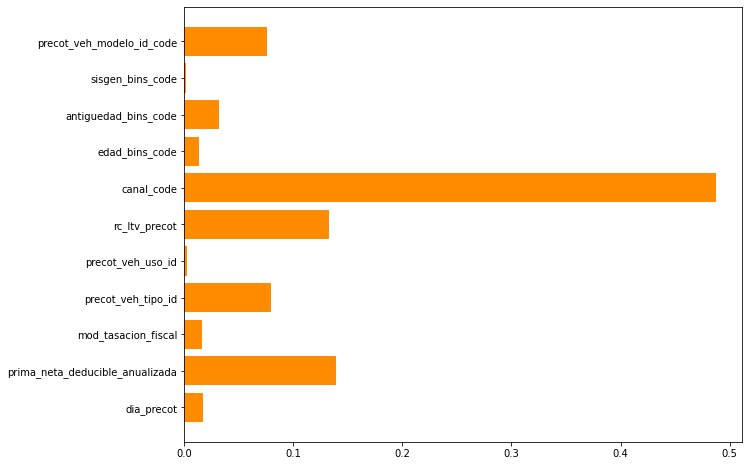

In [83]:
 # Features Importances
importances = dec_tree.feature_importances_
#importances = sorted(importances, reverse=True)

features = X_train.columns

# plot feature importance
plt.figure(figsize=(10,8))
plt.barh([x for x in features], importances, color = 'darkorange')
#plt.xticks(rotation=90)
plt.show();

## Metricas del Modelo

----------------------------------------------------------------------------
Metrics Report Model DecisionTreeClassifier -- Training Dataset
---------------------------------------------------------------------------- 


 METRICS RESUME MODEL
Precision: 0.755666 
Recall: 0.791358 
F1: 0.773100
AUC:  0.7677416407820208

 CONFUSION MATRIX


Verdadero  Falso
Verdadero      40726  14004
Falso          11419  43311

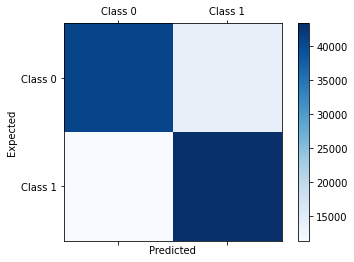


 METRICS MODEL


0             1  accuracy      macro avg   weighted avg
precision      0.781014      0.755666  0.767742       0.768340       0.768340
recall         0.744126      0.791358  0.767742       0.767742       0.767742
f1-score       0.762124      0.773100  0.767742       0.767612       0.767612
support    54730.000000  54730.000000  0.767742  109460.000000  109460.000000


 ROC CURVE MODEL


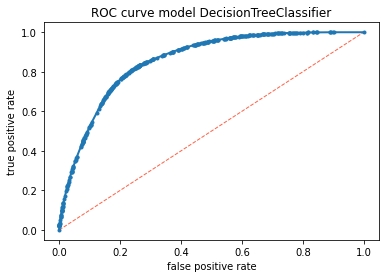


 PRECISION-RECALL CURVE


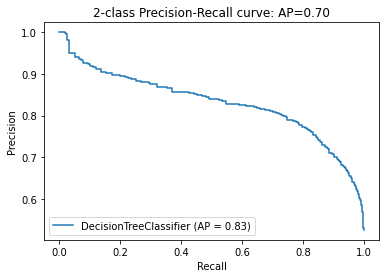


 TRADE-OFF PRECISION RECALL - TRAINING SET


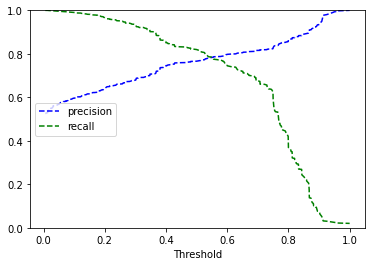


 
 ----------------------------------------------------------------------------
Metrics Report Model DecisionTreeClassifier -- Testing Dataset
---------------------------------------------------------------------------- 


 METRICS RESUME MODEL
Precision: 0.342674 
Recall: 0.801364 
F1: 0.480065
AUC:  0.767318986345436

 CONFUSION MATRIX


Verdadero  Falso
Verdadero      99121  36055
Falso           4659  18796

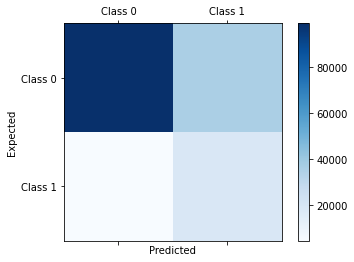


 METRICS MODEL


0             1  accuracy      macro avg   weighted avg
precision       0.955107      0.342674  0.743341       0.648890       0.864553
recall          0.733274      0.801364  0.743341       0.767319       0.743341
f1-score        0.829617      0.480065  0.743341       0.654841       0.777933
support    135176.000000  23455.000000  0.743341  158631.000000  158631.000000


 ROC CURVE MODEL


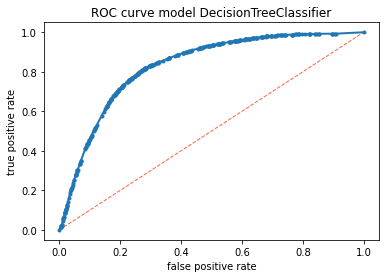


 PRECISION-RECALL CURVE


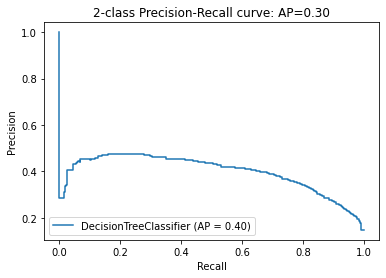


 TRADE-OFF PRECISION RECALL - TESTING SET


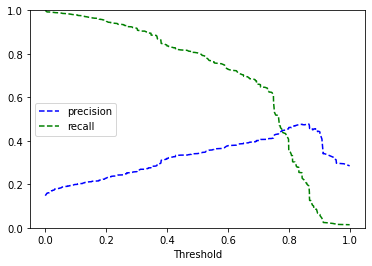

In [100]:
metrics_report(dec_tree, X_train, y_train, X_test, y_test)

## Desempeño del Modelo por Canal

### Canal Dealers

----------------------------------------------------------------------------
CANAL DEALERS
----------------------------------------------------------------------------
Metrics Report Model DecisionTreeClassifier -- Training Dataset
---------------------------------------------------------------------------- 


 METRICS RESUME MODEL
Precision: 0.766560 
Recall: 0.882772 
F1: 0.820572
AUC:  0.6786996768819507

 CONFUSION MATRIX


Verdadero  Falso
Verdadero      11121  12310
Falso           5368  40423

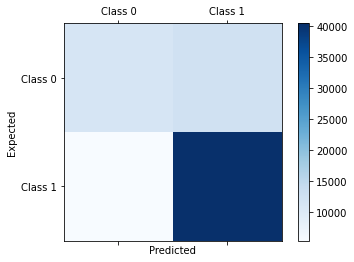


 METRICS MODEL


0             1  accuracy     macro avg  weighted avg
precision      0.674450      0.766560  0.744619      0.720505      0.735381
recall         0.474628      0.882772  0.744619      0.678700      0.744619
f1-score       0.557164      0.820572  0.744619      0.688868      0.731411
support    23431.000000  45791.000000  0.744619  69222.000000  69222.000000


 ROC CURVE MODEL


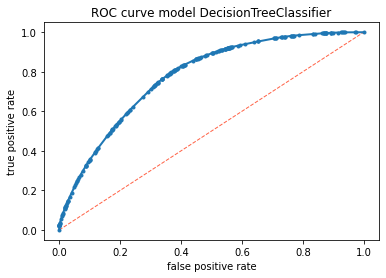


 PRECISION-RECALL CURVE


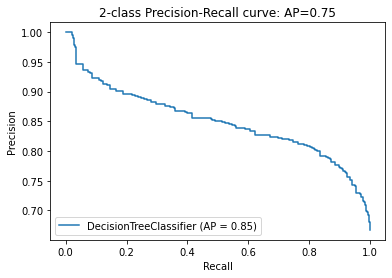


 TRADE-OFF PRECISION RECALL - TRAINING SET


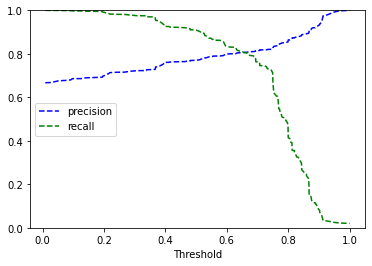


 
 ----------------------------------------------------------------------------
Metrics Report Model DecisionTreeClassifier -- Testing Dataset
---------------------------------------------------------------------------- 


 METRICS RESUME MODEL
Precision: 0.353695 
Recall: 0.897836 
F1: 0.507475
AUC:  0.673359038089262

 CONFUSION MATRIX


Verdadero  Falso
Verdadero      26120  32069
Falso           1997  17550

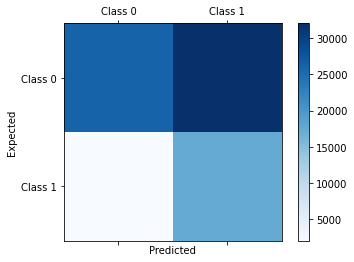


 METRICS MODEL


0             1  accuracy     macro avg  weighted avg
precision      0.928975      0.353695  0.561773      0.641335      0.784319
recall         0.448882      0.897836  0.561773      0.673359      0.561773
f1-score       0.605288      0.507475  0.561773      0.556381      0.580693
support    58189.000000  19547.000000  0.561773  77736.000000  77736.000000


 ROC CURVE MODEL


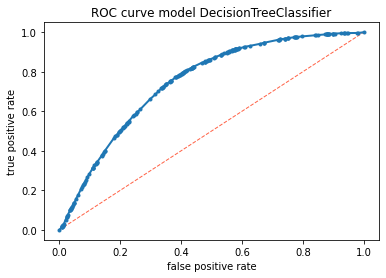


 PRECISION-RECALL CURVE


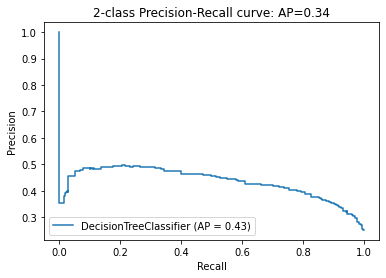


 TRADE-OFF PRECISION RECALL - TESTING SET


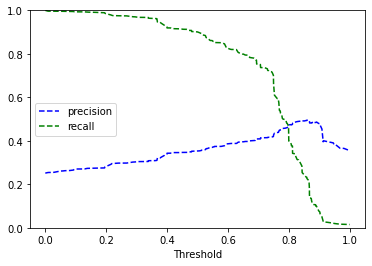

In [194]:
canal_report(dec_tree, 1, X_train, y_train, X_test, y_test)

### Canal Directo

----------------------------------------------------------------------------
CANAL DIRECTO
----------------------------------------------------------------------------
Metrics Report Model DecisionTreeClassifier -- Training Dataset
---------------------------------------------------------------------------- 


 METRICS RESUME MODEL
Precision: 0.644305 
Recall: 0.385156 
F1: 0.482113
AUC:  0.6328421821053302

 CONFUSION MATRIX


Verdadero  Falso
Verdadero      10473   1421
Falso           4109   2574

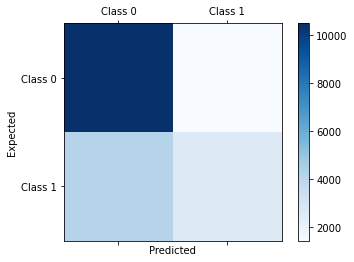


 METRICS MODEL


0            1  accuracy     macro avg  weighted avg
precision      0.718214     0.644305   0.70232      0.681260      0.691626
recall         0.880528     0.385156   0.70232      0.632842      0.702320
f1-score       0.791132     0.482113   0.70232      0.636622      0.679963
support    11894.000000  6683.000000   0.70232  18577.000000  18577.000000


 ROC CURVE MODEL


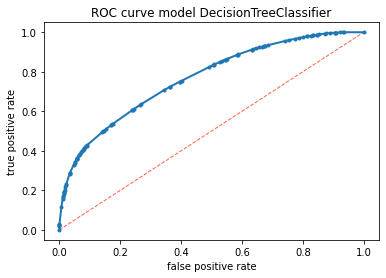


 PRECISION-RECALL CURVE


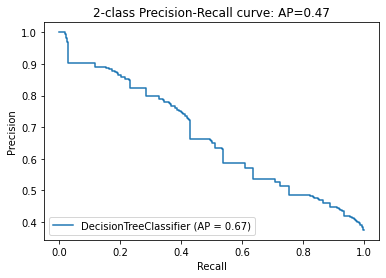


 TRADE-OFF PRECISION RECALL - TRAINING SET


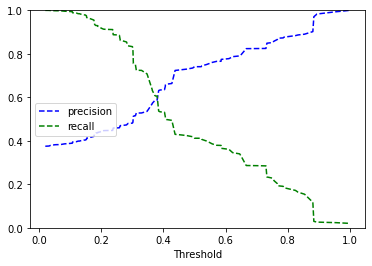


 
 ----------------------------------------------------------------------------
Metrics Report Model DecisionTreeClassifier -- Testing Dataset
---------------------------------------------------------------------------- 


 METRICS RESUME MODEL
Precision: 0.266422 
Recall: 0.377378 
F1: 0.312339
AUC:  0.6371942461263539

 CONFUSION MATRIX


Verdadero  Falso
Verdadero      26164   3004
Falso           1800   1091

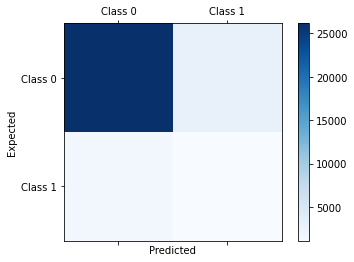


 METRICS MODEL


0            1  accuracy     macro avg  weighted avg
precision      0.935632     0.266422  0.850151      0.601027      0.875284
recall         0.897010     0.377378  0.850151      0.637194      0.850151
f1-score       0.915914     0.312339  0.850151      0.614126      0.861485
support    29168.000000  2891.000000  0.850151  32059.000000  32059.000000


 ROC CURVE MODEL


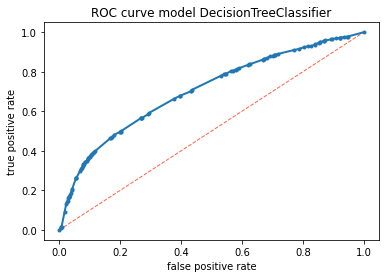


 PRECISION-RECALL CURVE


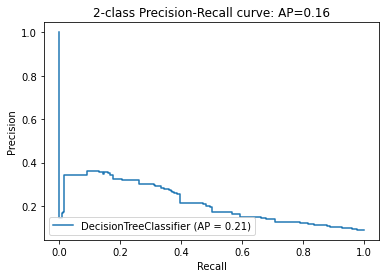


 TRADE-OFF PRECISION RECALL - TESTING SET


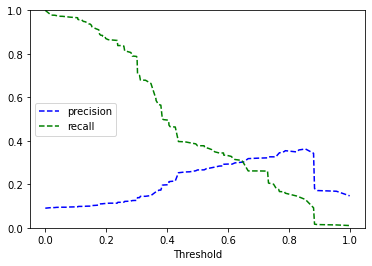

In [195]:
canal_report(dec_tree, 2, X_train, y_train, X_test, y_test)

### Canal Masivos

----------------------------------------------------------------------------
CANAL MASIVOS
----------------------------------------------------------------------------
Metrics Report Model DecisionTreeClassifier -- Training Dataset
---------------------------------------------------------------------------- 


 METRICS RESUME MODEL
Precision: 0.169811 
Recall: 0.055215 
F1: 0.083333
AUC:  0.5177580857357614

 CONFUSION MATRIX


Verdadero  Falso
Verdadero      13138    264
Falso            924     54

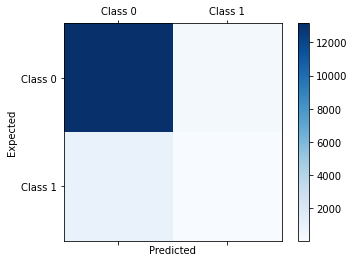


 METRICS MODEL


0           1  accuracy     macro avg  weighted avg
precision      0.934291    0.169811  0.917385      0.552051      0.882298
recall         0.980301    0.055215  0.917385      0.517758      0.917385
f1-score       0.956743    0.083333  0.917385      0.520038      0.897342
support    13402.000000  978.000000  0.917385  14380.000000  14380.000000


 ROC CURVE MODEL


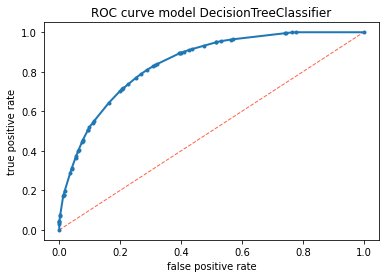


 PRECISION-RECALL CURVE


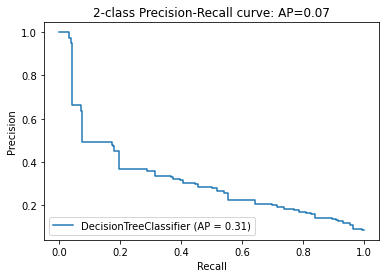


 TRADE-OFF PRECISION RECALL - TRAINING SET


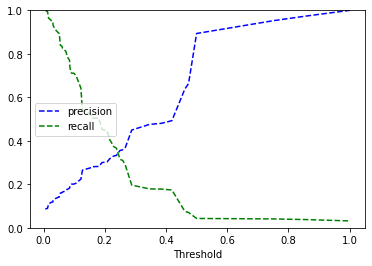


 
 ----------------------------------------------------------------------------
Metrics Report Model DecisionTreeClassifier -- Testing Dataset
---------------------------------------------------------------------------- 


 METRICS RESUME MODEL
Precision: 0.066667 
Recall: 0.013393 
F1: 0.022305
AUC:  0.5054283509167684

 CONFUSION MATRIX


Verdadero  Falso
Verdadero      33037     84
Falso            442      6

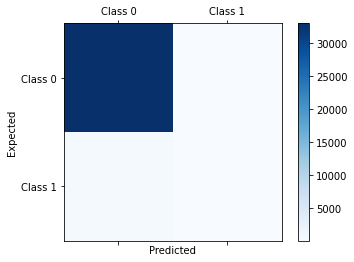


 METRICS MODEL


0           1  accuracy     macro avg  weighted avg
precision      0.986798    0.066667  0.984331      0.526732      0.974518
recall         0.997464    0.013393  0.984331      0.505428      0.984331
f1-score       0.992102    0.022305  0.984331      0.507203      0.979160
support    33121.000000  448.000000  0.984331  33569.000000  33569.000000


 ROC CURVE MODEL


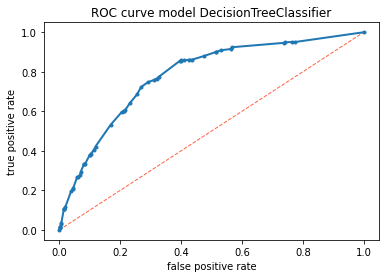


 PRECISION-RECALL CURVE


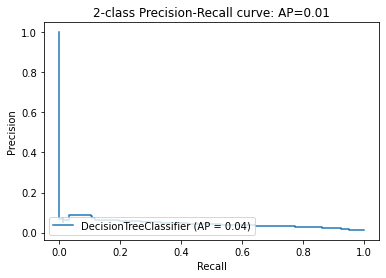


 TRADE-OFF PRECISION RECALL - TESTING SET


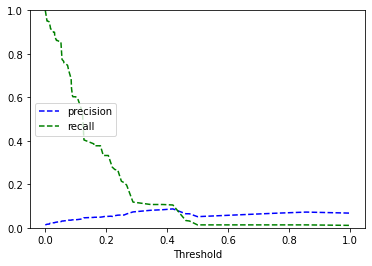

In [196]:
canal_report(dec_tree, 3, X_train, y_train, X_test, y_test)

### Canal Corredor

----------------------------------------------------------------------------
CANAL CORREDOR
----------------------------------------------------------------------------
Metrics Report Model DecisionTreeClassifier -- Training Dataset
---------------------------------------------------------------------------- 


 METRICS RESUME MODEL
Precision: 0.400875 
Recall: 0.215180 
F1: 0.280041
AUC:  0.5733571007923268

 CONFUSION MATRIX


Verdadero  Falso
Verdadero       5592    411
Falso           1003    275

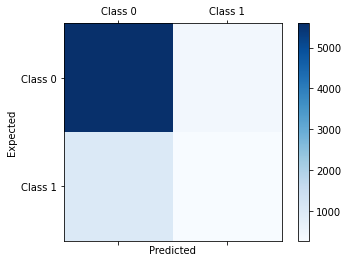


 METRICS MODEL


0            1  accuracy    macro avg  weighted avg
precision     0.847915     0.400875  0.805796     0.624395      0.769448
recall        0.931534     0.215180  0.805796     0.573357      0.805796
f1-score      0.887760     0.280041  0.805796     0.583900      0.781090
support    6003.000000  1278.000000  0.805796  7281.000000   7281.000000


 ROC CURVE MODEL


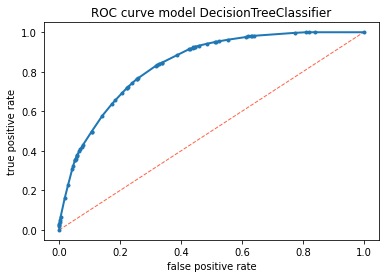


 PRECISION-RECALL CURVE


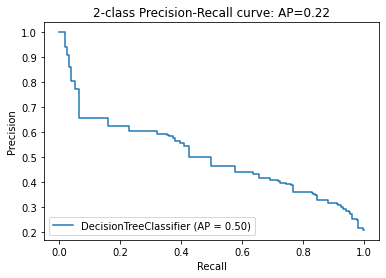


 TRADE-OFF PRECISION RECALL - TRAINING SET


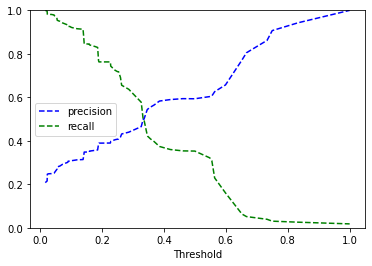


 
 ----------------------------------------------------------------------------
Metrics Report Model DecisionTreeClassifier -- Testing Dataset
---------------------------------------------------------------------------- 


 METRICS RESUME MODEL
Precision: 0.142311 
Recall: 0.261863 
F1: 0.184406
AUC:  0.6003830847710471

 CONFUSION MATRIX


Verdadero  Falso
Verdadero      13800    898
Falso            420    149

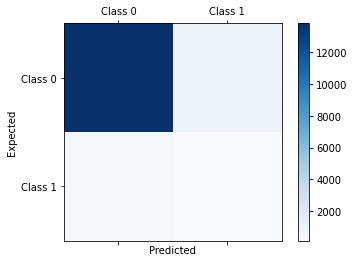


 METRICS MODEL


0           1  accuracy     macro avg  weighted avg
precision      0.970464    0.142311   0.91367      0.556388      0.939599
recall         0.938903    0.261863   0.91367      0.600383      0.913670
f1-score       0.954423    0.184406   0.91367      0.569414      0.925724
support    14698.000000  569.000000   0.91367  15267.000000  15267.000000


 ROC CURVE MODEL


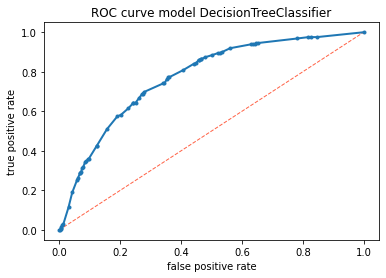


 PRECISION-RECALL CURVE


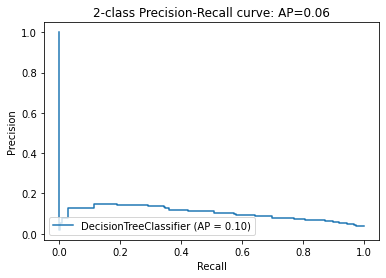


 TRADE-OFF PRECISION RECALL - TESTING SET


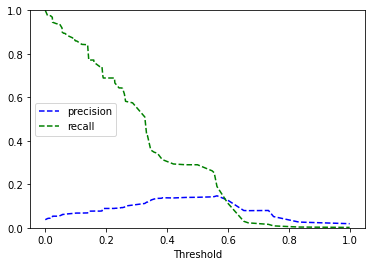

In [197]:
canal_report(dec_tree, 4, X_train, y_train, X_test, y_test)

## Comparación de Desempeño por Canal 

### Comparación Train dataset

Metrics Comparison - Canales


DEALERS   DIRECTO   MASIVOS  CORREDOR
AUC        0.67870  0.632842  0.517758  0.573357
Accuracy   0.74462  0.702320  0.917390  0.805800
Presicion  0.73538  0.691630  0.882300  0.769450
Recall     0.74462  0.702320  0.917390  0.805800
F1         0.73141  0.679960  0.897340  0.781090

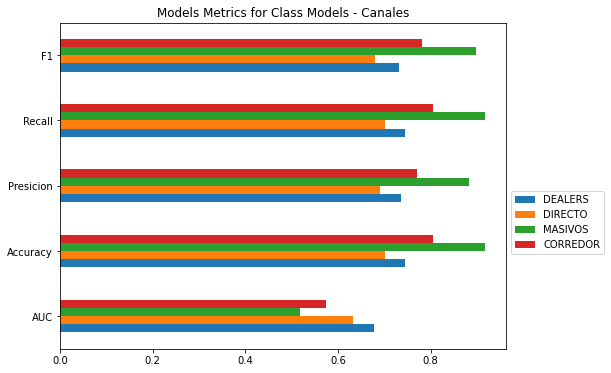

In [187]:
canal_comparison(dec_tree, X_train, y_train)

### Comparación Test dataset

Metrics Comparison - Canales


DEALERS   DIRECTO   MASIVOS  CORREDOR
AUC        0.578258  0.526629  0.505292  0.516554
Accuracy   0.745240  0.902990  0.984060  0.952320
Presicion  0.707940  0.860700  0.974430  0.932600
Recall     0.745240  0.902990  0.984060  0.952320
F1         0.712440  0.873190  0.979020  0.941660

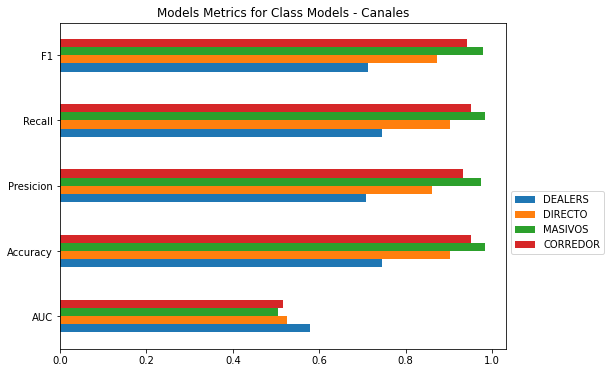

In [189]:
canal_comparison(dec_tree, X_test, y_test)

# Modelacion 2

## Filtro de variables a considerar

In [119]:
# Borrando variables que no se usaran
data_model_2.drop(columns = ['rut_num', 'precot_veh_tipo', 
                             'precot_veh_uso', 'numero_semana', 'cotizacion', 
                             'santander', 'week enddate', 'tasa_conversion', 
                             'edad_bins_code', 'antiguedad_bins_code', 
                             'sisgen_bins_code'],
                  inplace = True)

# Vista previa de los registros a modelar
display(data_model_2)

antiguedad_veh  dia_precot  ...  canal_code  precot_veh_modelo_id_code
0                    0          25  ...           1                        598
1                    0          25  ...           1                        742
3                    0           2  ...           1                        598
4                    0          24  ...           1                        597
5                    0          21  ...           1                        823
...                ...         ...  ...         ...                        ...
983230               7           8  ...           2                         66
983232              11          29  ...           2                        456
983233              11          30  ...           2                        276
983234              11          27  ...           2                        572
983235              12           7  ...           1                        182

[528770 rows x 12 columns]

## Data Split

In [120]:
# Genera data de train y test
data_train2, data_test2 = train_test_split(data_model_2, test_size=.3, stratify = data_model_2.iloc[:,5], random_state = 0)

# Separando X e y para train & test
X_train2 = data_train2.drop(columns = ['venta'])
y_train2 = data_train2['venta'].astype(int)

X_test2 = data_test2.drop(columns = ['venta'])
y_test2 = data_test2['venta'].astype(int)

## Optimización de Hiperparametros

In [121]:
#Fit Decision Tree Classifier
tree_params_m2 = {'criterion':['gini','entropy'],
                  'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50]}

tree_grid_m2 = GridSearchCV(estimator = DecisionTreeClassifier(random_state = 16626),
                            param_grid = tree_params_m2,
                            cv = 5,
                            n_jobs = -1,
                            scoring = 'f1_macro').fit(X_train2, y_train2)

print('Mejor score: ', tree_grid_m2.best_score_)
print('Mejores Parametros: ', tree_grid_m2.best_params_)

Mejor score:  0.6184642554866494
Mejores Parametros:  {'criterion': 'gini', 'max_depth': 15}


## Grafico de Desempeño

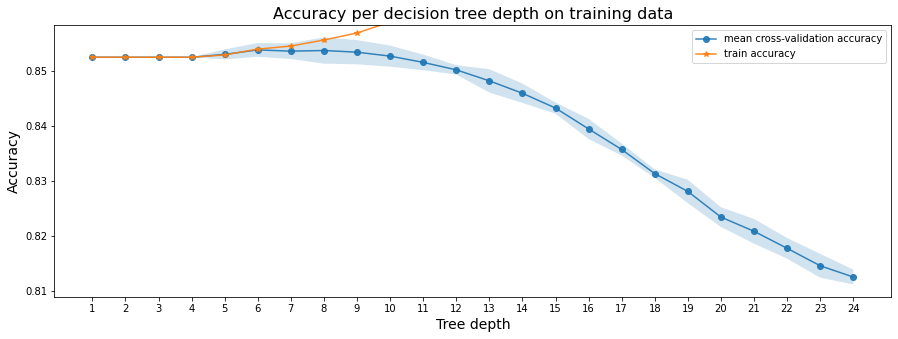

In [123]:
# fitting trees of depth 1 to 24
sm_tree_depths = range(1,25)
sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = run_cross_validation_on_trees(X_train2, y_train2, sm_tree_depths)

# plotting accuracy
plot_cross_validation_on_trees(sm_tree_depths, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores, 
                               'Accuracy per decision tree depth on training data')                             

In [125]:
# Best params
idx_max = sm_cv_scores_mean.argmax()
sm_best_tree_depth = sm_tree_depths[idx_max]
sm_best_tree_cv_score = sm_cv_scores_mean[idx_max]
sm_best_tree_cv_score_std = sm_cv_scores_std[idx_max]

print('The depth-{} tree achieves the best mean cross-validation accuracy {} +/- {}% on training dataset'.format(
      sm_best_tree_depth, round(sm_best_tree_cv_score*100,5), round(sm_best_tree_cv_score_std*100, 5)))

The depth-6 tree achieves the best mean cross-validation accuracy 85.38765 +/- 0.06272% on training dataset


## Ajuste y Predicciones del modelo

In [126]:
dec_tree_m2 = DecisionTreeClassifier(criterion = tree_grid_m2.best_params_['criterion'],
                                     max_depth = tree_grid_m2.best_params_['max_depth'],
                                     random_state = 16626).fit(X_train2, y_train2)  

# Train Predict
y_train_pred_m2 = cross_val_predict(dec_tree_m2, X_train2, y_train2, cv=10)
y_train_proba_m2 = dec_tree_m2.predict_proba(X_train2)

# Test Predict
y_test_pred_m2 = dec_tree_m2.predict(X_test2)
y_test_proba_m2 = dec_tree_m2.predict_proba(X_test2)

## Features Importances

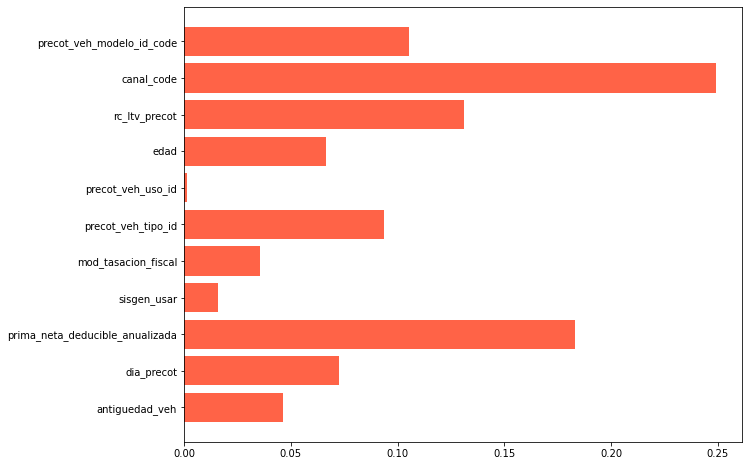

In [127]:
 # Features Importances
importances = dec_tree_m2.feature_importances_

# columns names
features = X_train2.columns

# plot feature importance
plt.figure(figsize=(10,8))
plt.barh([x for x in features], importances, color = 'tomato')
#plt.xticks(rotation=90)
plt.show();

## Metricas del Modelo

----------------------------------------------------------------------------
Metrics Report Model DecisionTreeClassifier -- Training Dataset
---------------------------------------------------------------------------- 


 METRICS RESUME MODEL
Precision: 0.443659 
Recall: 0.258744 
F1: 0.326861
AUC:  0.6013102022281414

 CONFUSION MATRIX


Verdadero  Falso
Verdadero     297846  17710
Falso          40460  14123

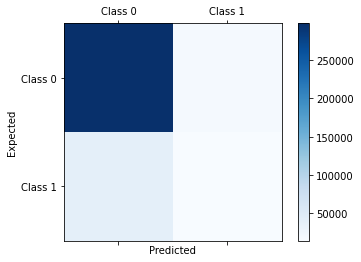


 METRICS MODEL


0             1  accuracy      macro avg   weighted avg
precision       0.880404      0.443659  0.842843       0.662032       0.815999
recall          0.943877      0.258744  0.842843       0.601310       0.842843
f1-score        0.911036      0.326861  0.842843       0.618949       0.824890
support    315556.000000  54583.000000  0.842843  370139.000000  370139.000000


 ROC CURVE MODEL


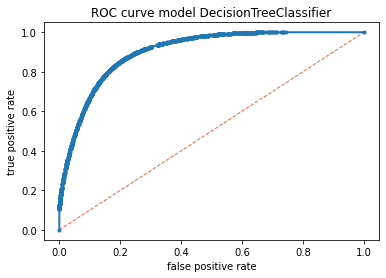


 PRECISION-RECALL CURVE


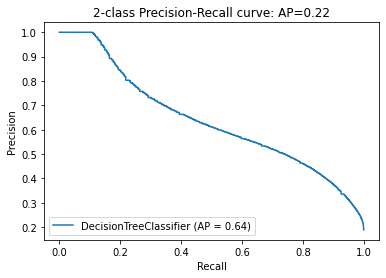


 TRADE-OFF PRECISION RECALL - TRAINING SET


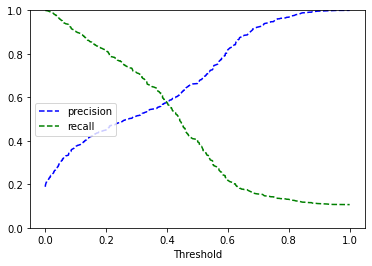


 
 ----------------------------------------------------------------------------
Metrics Report Model DecisionTreeClassifier -- Testing Dataset
---------------------------------------------------------------------------- 


 METRICS RESUME MODEL
Precision: 0.450068 
Recall: 0.267901 
F1: 0.335874
AUC:  0.6053418434195899

 CONFUSION MATRIX


Verdadero  Falso
Verdadero     127303   7726
Falso          17279   6323

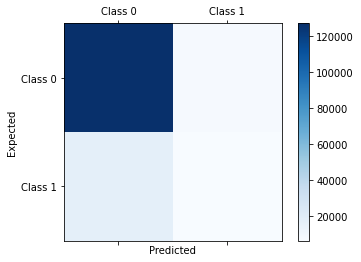


 METRICS MODEL


0             1  accuracy      macro avg   weighted avg
precision       0.880490      0.450068   0.84237       0.665279       0.816449
recall          0.942783      0.267901   0.84237       0.605342       0.842370
f1-score        0.910572      0.335874   0.84237       0.623223       0.825065
support    135029.000000  23602.000000   0.84237  158631.000000  158631.000000


 ROC CURVE MODEL


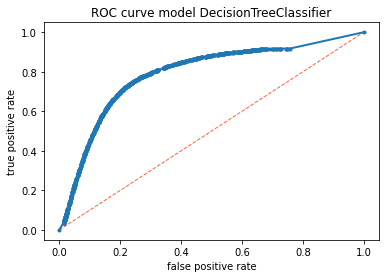


 PRECISION-RECALL CURVE


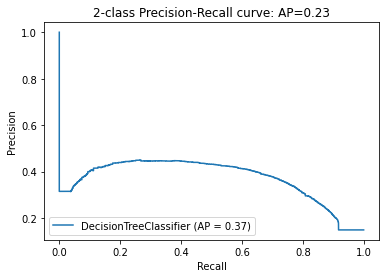


 TRADE-OFF PRECISION RECALL - TESTING SET


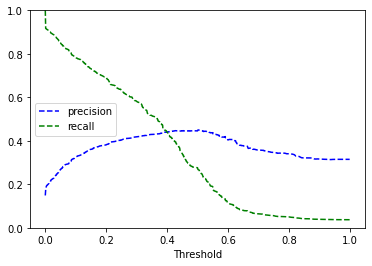

In [128]:
metrics_report(dec_tree_m2, X_train2, y_train2, X_test2, y_test2)

## Desempeño del Modelo por Canal

### Canal Dealers

----------------------------------------------------------------------------
CANAL DEALERS
----------------------------------------------------------------------------
Metrics Report Model DecisionTreeClassifier -- Training Dataset
---------------------------------------------------------------------------- 


 METRICS RESUME MODEL
Precision: 0.454008 
Recall: 0.301722 
F1: 0.362522
AUC:  0.5898426801219883

 CONFUSION MATRIX


Verdadero  Falso
Verdadero     118971  16537
Falso          31824  13751

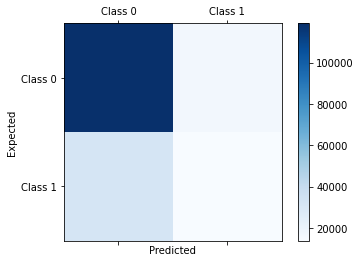


 METRICS MODEL


0             1  accuracy      macro avg   weighted avg
precision       0.788959      0.454008  0.732935       0.621483       0.704658
recall          0.877963      0.301722  0.732935       0.589843       0.732935
f1-score        0.831085      0.362522  0.732935       0.596803       0.713157
support    135508.000000  45575.000000  0.732935  181083.000000  181083.000000


 ROC CURVE MODEL


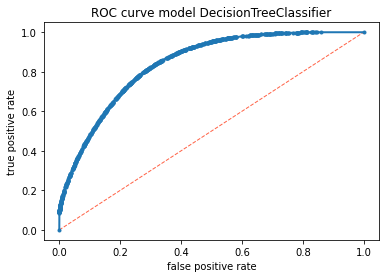


 PRECISION-RECALL CURVE


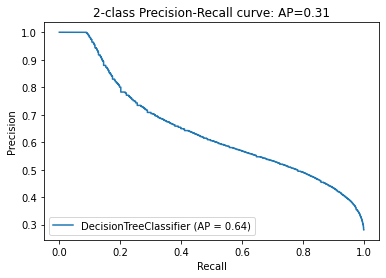


 TRADE-OFF PRECISION RECALL - TRAINING SET


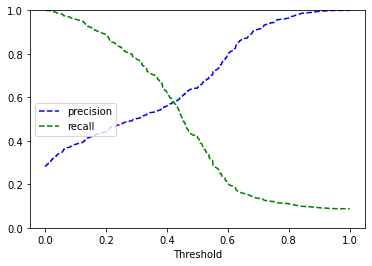


 
 ----------------------------------------------------------------------------
Metrics Report Model DecisionTreeClassifier -- Testing Dataset
---------------------------------------------------------------------------- 


 METRICS RESUME MODEL
Precision: 0.470757 
Recall: 0.298942 
F1: 0.365673
AUC:  0.5923799499572774

 CONFUSION MATRIX


Verdadero  Falso
Verdadero      51528   6642
Falso          13855   5908

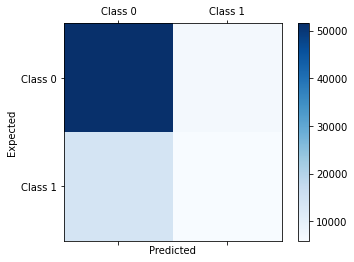


 METRICS MODEL


0             1  accuracy     macro avg  weighted avg
precision      0.788095      0.470757  0.736992      0.629426      0.707621
recall         0.885817      0.298942  0.736992      0.592380      0.736992
f1-score       0.834104      0.365673  0.736992      0.599888      0.715315
support    58170.000000  19763.000000  0.736992  77933.000000  77933.000000


 ROC CURVE MODEL


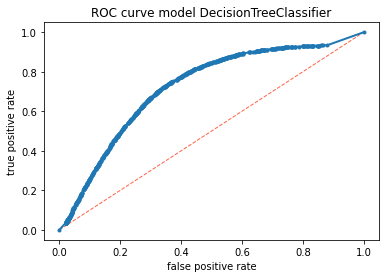


 PRECISION-RECALL CURVE


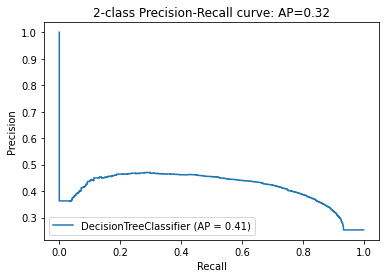


 TRADE-OFF PRECISION RECALL - TESTING SET


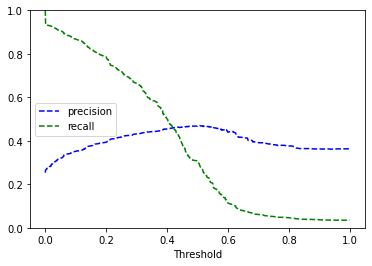

In [203]:
canal_report(dec_tree_m2, 1, X_train2, y_train2, X_test2, y_test2)

### Canal Directo

----------------------------------------------------------------------------
CANAL DIRECTO
----------------------------------------------------------------------------
Metrics Report Model DecisionTreeClassifier -- Training Dataset
---------------------------------------------------------------------------- 


 METRICS RESUME MODEL
Precision: 0.285545 
Recall: 0.143986 
F1: 0.191439
AUC:  0.5544271831399069

 CONFUSION MATRIX


Verdadero  Falso
Verdadero      66382   2417
Falso           5743    966

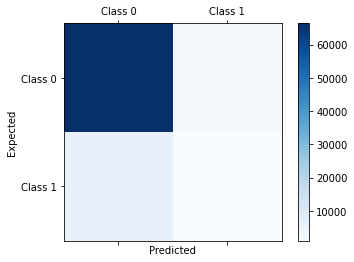


 METRICS MODEL


0            1  accuracy     macro avg  weighted avg
precision      0.920374     0.285545  0.891932      0.602960      0.863969
recall         0.964869     0.143986  0.891932      0.554427      0.891932
f1-score       0.942096     0.191439  0.891932      0.566768      0.875399
support    68799.000000  6709.000000  0.891932  75508.000000  75508.000000


 ROC CURVE MODEL


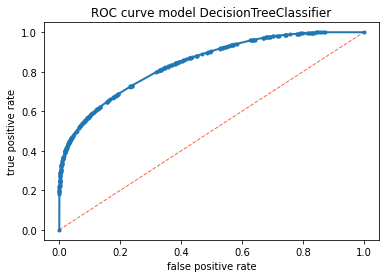


 PRECISION-RECALL CURVE


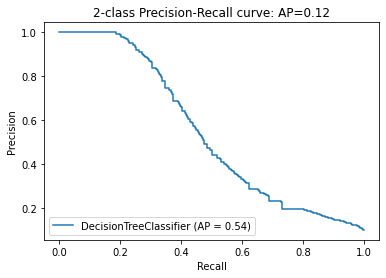


 TRADE-OFF PRECISION RECALL - TRAINING SET


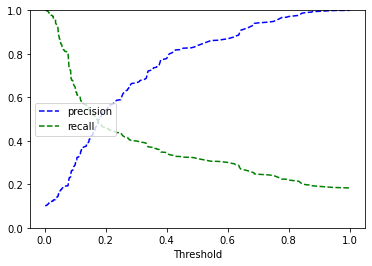


 
 ----------------------------------------------------------------------------
Metrics Report Model DecisionTreeClassifier -- Testing Dataset
---------------------------------------------------------------------------- 


 METRICS RESUME MODEL
Precision: 0.328634 
Recall: 0.130192 
F1: 0.186500
AUC:  0.5521160521304462

 CONFUSION MATRIX


Verdadero  Falso
Verdadero      28591    762
Falso           2492    373

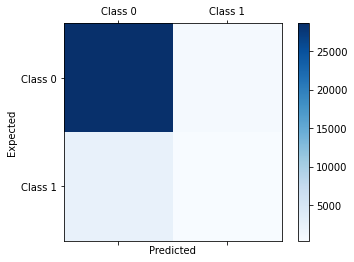


 METRICS MODEL


0            1  accuracy     macro avg  weighted avg
precision      0.919828     0.328634  0.899001      0.624231      0.867255
recall         0.974040     0.130192  0.899001      0.552116      0.899001
f1-score       0.946158     0.186500  0.899001      0.566329      0.878605
support    29353.000000  2865.000000  0.899001  32218.000000  32218.000000


 ROC CURVE MODEL


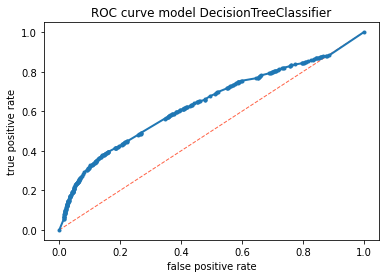


 PRECISION-RECALL CURVE


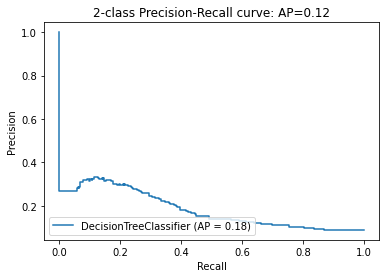


 TRADE-OFF PRECISION RECALL - TESTING SET


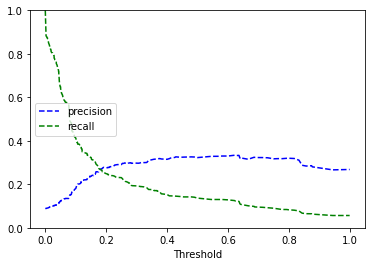

In [204]:
canal_report(dec_tree_m2, 2, X_train2, y_train2, X_test2, y_test2)

### Canal Masivos

----------------------------------------------------------------------------
CANAL MASIVOS
----------------------------------------------------------------------------
Metrics Report Model DecisionTreeClassifier -- Training Dataset
---------------------------------------------------------------------------- 


 METRICS RESUME MODEL
Precision: 0.051318 
Recall: 0.036779 
F1: 0.042849
AUC:  0.5139365370278329

 CONFUSION MATRIX


Verdadero  Falso
Verdadero      76116    684
Falso            969     37

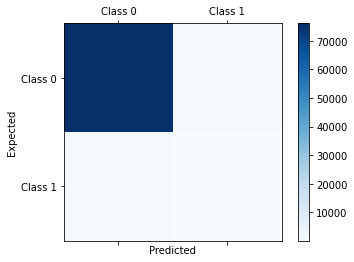


 METRICS MODEL


0            1  accuracy     macro avg  weighted avg
precision      0.987429     0.051318  0.978755      0.519374      0.975326
recall         0.991094     0.036779  0.978755      0.513937      0.978755
f1-score       0.989258     0.042849  0.978755      0.516054      0.977022
support    76800.000000  1006.000000  0.978755  77806.000000  77806.000000


 ROC CURVE MODEL


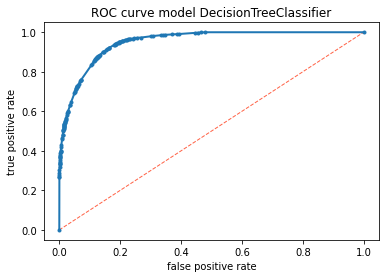


 PRECISION-RECALL CURVE


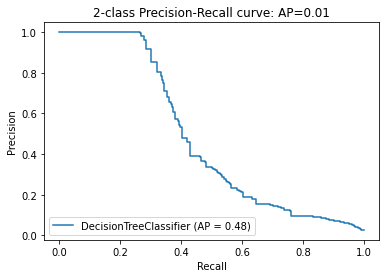


 TRADE-OFF PRECISION RECALL - TRAINING SET


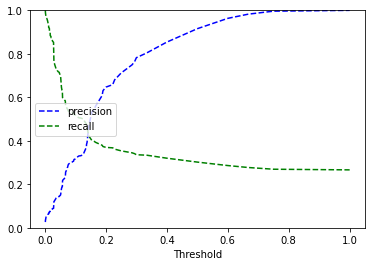


 
 ----------------------------------------------------------------------------
Metrics Report Model DecisionTreeClassifier -- Testing Dataset
---------------------------------------------------------------------------- 


 METRICS RESUME MODEL
Precision: 0.049383 
Recall: 0.019048 
F1: 0.027491
AUC:  0.5071835973850988

 CONFUSION MATRIX


Verdadero  Falso
Verdadero      32749    154
Falso            412      8

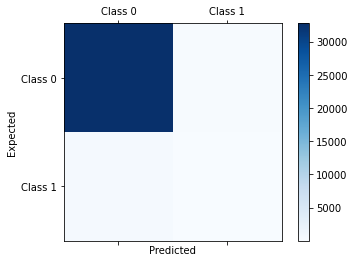


 METRICS MODEL


0           1  accuracy     macro avg  weighted avg
precision      0.987576    0.049383  0.983015      0.518479      0.975751
recall         0.995320    0.019048  0.983015      0.507184      0.983015
f1-score       0.991433    0.027491  0.983015      0.509462      0.979283
support    32903.000000  420.000000  0.983015  33323.000000  33323.000000


 ROC CURVE MODEL


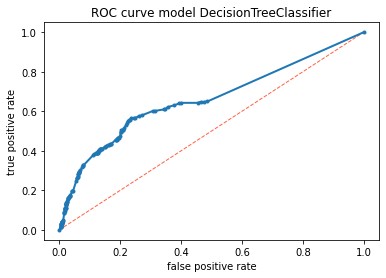


 PRECISION-RECALL CURVE


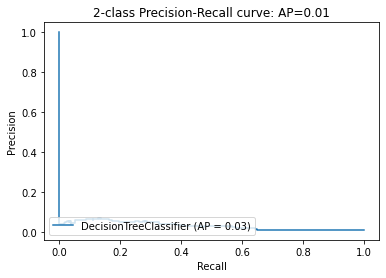


 TRADE-OFF PRECISION RECALL - TESTING SET


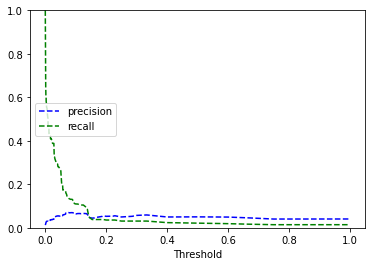

In [205]:
canal_report(dec_tree_m2, 3, X_train2, y_train2, X_test2, y_test2)

### Canal Corredor

----------------------------------------------------------------------------
CANAL CORREDOR
----------------------------------------------------------------------------
Metrics Report Model DecisionTreeClassifier -- Training Dataset
---------------------------------------------------------------------------- 


 METRICS RESUME MODEL
Precision: 0.112936 
Recall: 0.085073 
F1: 0.097045
AUC:  0.5299964593411195

 CONFUSION MATRIX


Verdadero  Falso
Verdadero      33585    864
Falso           1183    110

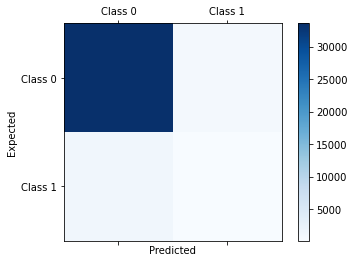


 METRICS MODEL


0            1  accuracy     macro avg  weighted avg
precision      0.965974     0.112936  0.942728      0.539455      0.935115
recall         0.974919     0.085073  0.942728      0.529996      0.942728
f1-score       0.970426     0.097045  0.942728      0.533735      0.938831
support    34449.000000  1293.000000  0.942728  35742.000000  35742.000000


 ROC CURVE MODEL


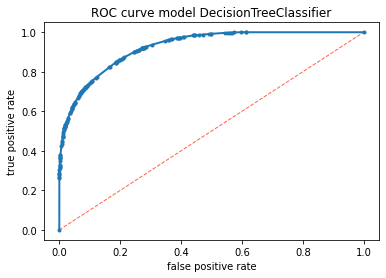


 PRECISION-RECALL CURVE


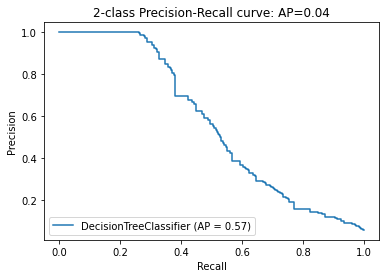


 TRADE-OFF PRECISION RECALL - TRAINING SET


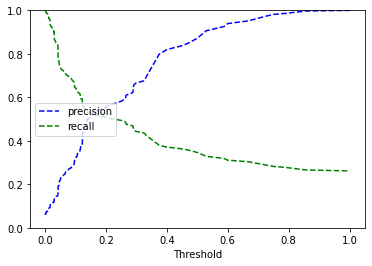


 
 ----------------------------------------------------------------------------
Metrics Report Model DecisionTreeClassifier -- Testing Dataset
---------------------------------------------------------------------------- 


 METRICS RESUME MODEL
Precision: 0.168317 
Recall: 0.061372 
F1: 0.089947
AUC:  0.5249336778877591

 CONFUSION MATRIX


Verdadero  Falso
Verdadero      14435    168
Falso            520     34

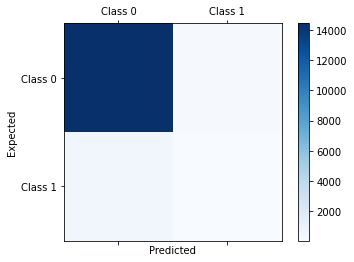


 METRICS MODEL


0           1  accuracy     macro avg  weighted avg
precision      0.965229    0.168317  0.954608      0.566773      0.936101
recall         0.988496    0.061372  0.954608      0.524934      0.954608
f1-score       0.976724    0.089947  0.954608      0.533335      0.944311
support    14603.000000  554.000000  0.954608  15157.000000  15157.000000


 ROC CURVE MODEL


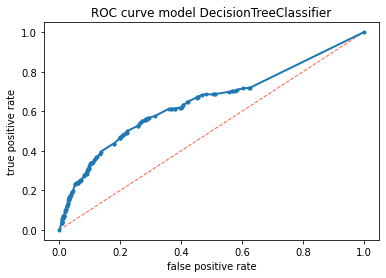


 PRECISION-RECALL CURVE


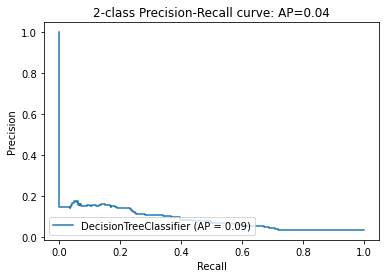


 TRADE-OFF PRECISION RECALL - TESTING SET


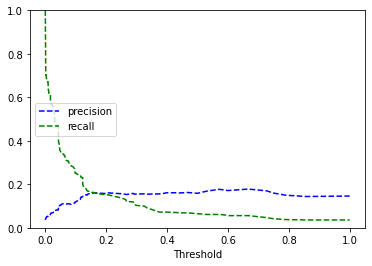

In [206]:
canal_report(dec_tree_m2, 4, X_train2, y_train2, X_test2, y_test2)

## Comparación de Desempeño por Canal 

### Comparación Train dataset

Metrics Comparison - Canales


DEALERS   DIRECTO   MASIVOS  CORREDOR
AUC        0.589843  0.554427  0.513937  0.529996
Accuracy   0.732930  0.891930  0.978750  0.942730
Presicion  0.704660  0.863970  0.975330  0.935120
Recall     0.732930  0.891930  0.978750  0.942730
F1         0.713160  0.875400  0.977020  0.938830

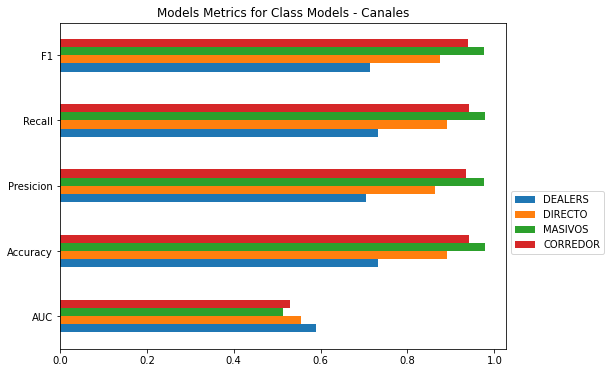

In [198]:
canal_comparison(dec_tree_m2, X_train2, y_train2)

### Comparación Test dataset

Metrics Comparison - Canales


DEALERS   DIRECTO   MASIVOS  CORREDOR
AUC        0.584909  0.550553  0.513227  0.531751
Accuracy   0.722220  0.880660  0.976380  0.939300
Presicion  0.696080  0.858670  0.975790  0.934440
Recall     0.722220  0.880660  0.976380  0.939300
F1         0.705040  0.868590  0.976080  0.936840

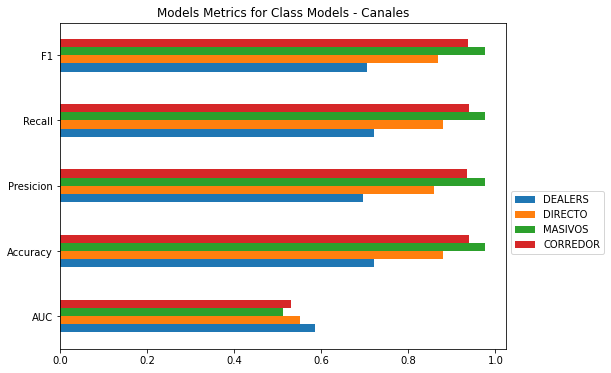

In [199]:
canal_comparison(dec_tree_m2, X_test2, y_test2)

# Modelacion 3

## Filtro y Split

In [85]:
# Borrando variables que no se usaran
data_model_3.drop(columns = ['rut_num', 'antiguedad_veh', 'sisgen_usar',
                             'precot_veh_tipo', 'precot_veh_uso', 'numero_semana', 
                             'edad', 'cotizacion', 'santander', 'week enddate', 
                             'tasa_conversion', 'edad'],
                 inplace = True)

# Genera data de train y test
data_train3, data_test3 = train_test_split(data_model_3, test_size=.3, stratify = data_model_1.iloc[:,5], random_state = 0)

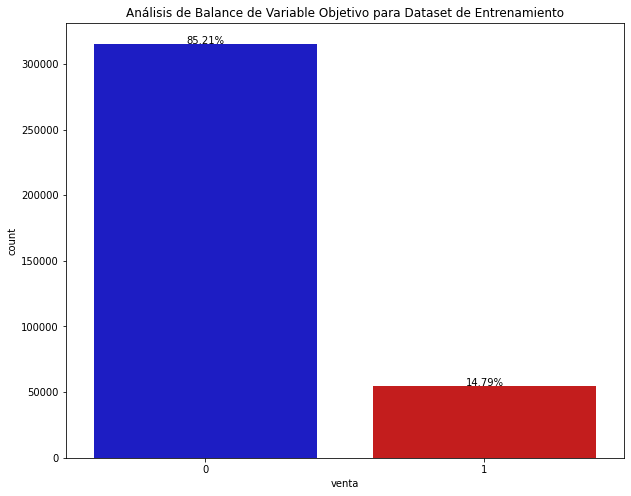

In [86]:
# Graficamente
total = float(len(data_train3))

plt.figure(figsize=(10,8))
ax = sns.countplot('venta', data = data_train3, 
                   palette = ["#0101DF", "#DF0101"]);
plt.title('Análisis de Balance de Variable Objetivo para Dataset de Entrenamiento')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            str(('{:1.2f}'.format((height/total)*100))) + '%',
            ha="center") 

## Control del Desbalance: Remuestreo 70-30

In [106]:
# Subsampling
data = data_train3.sample(frac = 1) # Remuestro

target_1 = data.loc[data['venta'] == 1]
target_0 = data.loc[data['venta'] == 0][:(math.trunc(len(target_1)/0.3)-len(target_1))]

sub_sample = pd.concat([target_1,target_0])
sub_sample = sub_sample.sample(frac = 1, random_state = 0).reset_index(drop = True)

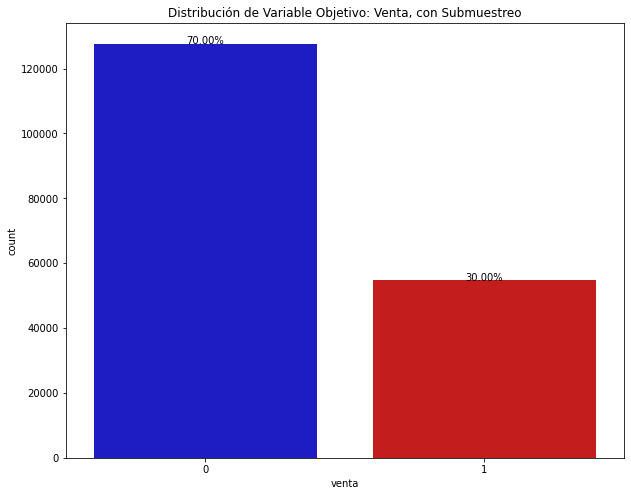

In [107]:
# Graficamente
total = float(len(sub_sample))

plt.figure(figsize=(10,8))
ax = sns.countplot('venta', data = sub_sample, 
                   palette = ["#0101DF", "#DF0101"]);
plt.title('Distribución de Variable Objetivo: Venta, con Submuestreo')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            str(('{:1.2f}'.format((height/total)*100))) + '%',
            ha="center") 

## Separando Vector Objetivo y Matriz de Diseño

In [109]:
# Separando X e y para train & test
X_train3 = sub_sample.drop(columns = ['venta'])
y_train3 = sub_sample['venta'].astype(int)

X_test3 = data_test3.drop(columns = ['venta'])
y_test3 = data_test3['venta'].astype(int)

## Optimización de Hiperparametros

In [110]:
#Fit Decision Tree Classifier
tree_params_m3 = {'criterion':['gini','entropy'],
                  'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50]}

tree_grid_m3 = GridSearchCV(estimator = DecisionTreeClassifier(random_state = 16626),
                            param_grid = tree_params_m3,
                            cv = 5,
                            n_jobs = -1,
                            scoring = 'f1_macro').fit(X_train3, y_train3)

print('Mejor score: ', tree_grid_m3.best_score_)
print('Mejores Parametros: ', tree_grid_m3.best_params_)

Mejor score:  0.7411151991203244
Mejores Parametros:  {'criterion': 'entropy', 'max_depth': 11}


## Grafico de Desempeño

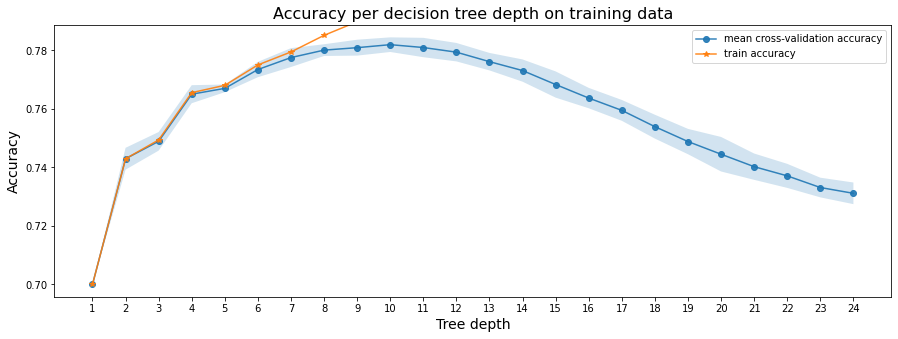

In [113]:
# fitting trees of depth 1 to 24
sm_tree_depths = range(1,25)
sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = run_cross_validation_on_trees(X_train3, y_train3, sm_tree_depths)

# plotting accuracy
plot_cross_validation_on_trees(sm_tree_depths, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores, 
                               'Accuracy per decision tree depth on training data')                             

In [114]:
# Best params
idx_max = sm_cv_scores_mean.argmax()
sm_best_tree_depth = sm_tree_depths[idx_max]
sm_best_tree_cv_score = sm_cv_scores_mean[idx_max]
sm_best_tree_cv_score_std = sm_cv_scores_std[idx_max]

print('The depth-{} tree achieves the best mean cross-validation accuracy {} +/- {}% on training dataset'.format(
      sm_best_tree_depth, round(sm_best_tree_cv_score*100,5), round(sm_best_tree_cv_score_std*100, 5)))

The depth-10 tree achieves the best mean cross-validation accuracy 78.19693 +/- 0.12499% on training dataset


## Ajuste y Predicciones del modelo

In [130]:
dec_tree_m3 = DecisionTreeClassifier(criterion = tree_grid_m3.best_params_['criterion'],
                                     max_depth = tree_grid_m3.best_params_['max_depth'],
                                     random_state = 16626).fit(X_train3, y_train3)  

# Train Predict
y_train_pred_m3 = cross_val_predict(dec_tree_m3, X_train3, y_train3, cv=10)
y_train_proba_m3 = dec_tree_m3.predict_proba(X_train3)

# Test Predict
y_test_pred_m3 = dec_tree_m3.predict(X_test3)
y_test_proba_m3 = dec_tree_m3.predict_proba(X_test3)

## Features Importances

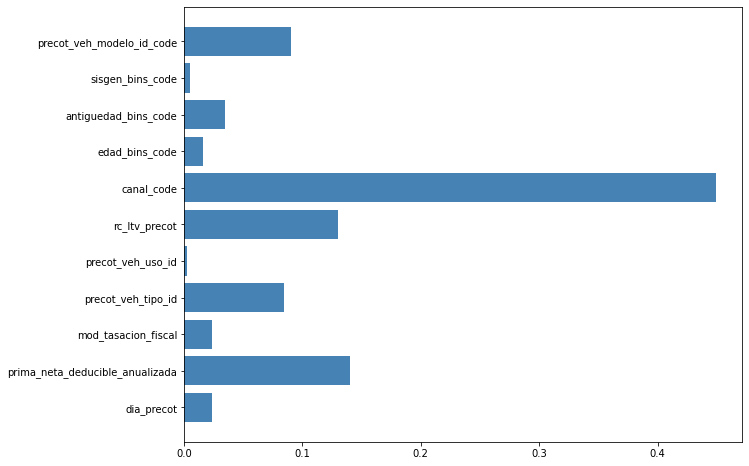

In [132]:
 # Features Importances
importances = dec_tree_m3.feature_importances_
#importances = sorted(importances, reverse=True)

features = X_train3.columns

# plot feature importance
plt.figure(figsize=(10,8))
plt.barh([x for x in features], importances, color = 'steelblue')
#plt.xticks(rotation=90)
plt.show();

## Metricas del Modelo

----------------------------------------------------------------------------
Metrics Report Model DecisionTreeClassifier -- Training Dataset
---------------------------------------------------------------------------- 


 METRICS RESUME MODEL
Precision: 0.641336 
Recall: 0.632688 
F1: 0.636982
AUC:  0.7405234114994168

 CONFUSION MATRIX


Verdadero  Falso
Verdadero     108338  19365
Falso          20103  34627

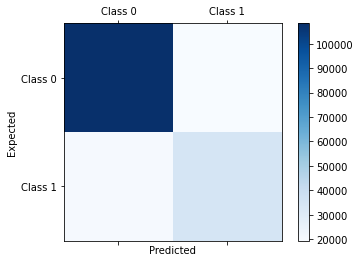


 METRICS MODEL


0             1  accuracy      macro avg   weighted avg
precision       0.843485      0.641336  0.783658       0.742410       0.782840
recall          0.848359      0.632688  0.783658       0.740523       0.783658
f1-score        0.845915      0.636982  0.783658       0.741449       0.783235
support    127703.000000  54730.000000  0.783658  182433.000000  182433.000000


 ROC CURVE MODEL


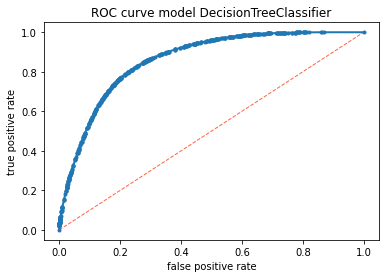


 PRECISION-RECALL CURVE


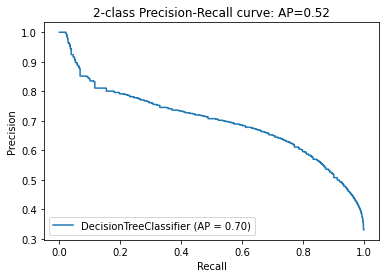


 TRADE-OFF PRECISION RECALL - TRAINING SET


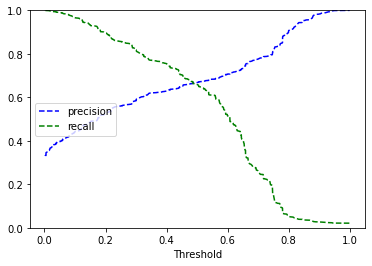


 
 ----------------------------------------------------------------------------
Metrics Report Model DecisionTreeClassifier -- Testing Dataset
---------------------------------------------------------------------------- 


 METRICS RESUME MODEL
Precision: 0.415574 
Recall: 0.624558 
F1: 0.499072
AUC:  0.7360781748842382

 CONFUSION MATRIX


Verdadero  Falso
Verdadero     114575  20601
Falso           8806  14649

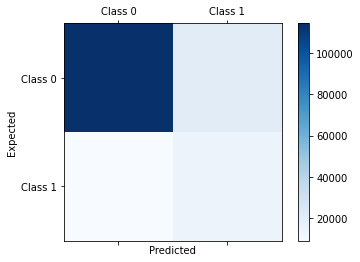


 METRICS MODEL


0             1  accuracy      macro avg   weighted avg
precision       0.928628      0.415574   0.81462       0.672101       0.852768
recall          0.847599      0.624558   0.81462       0.736078       0.814620
f1-score        0.886265      0.499072   0.81462       0.692668       0.829015
support    135176.000000  23455.000000   0.81462  158631.000000  158631.000000


 ROC CURVE MODEL


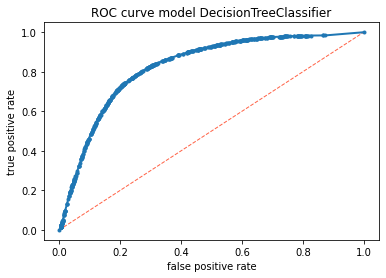


 PRECISION-RECALL CURVE


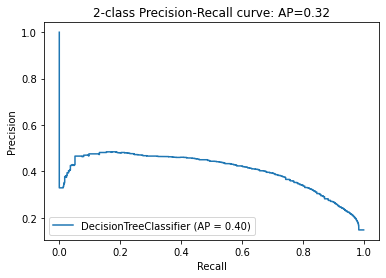


 TRADE-OFF PRECISION RECALL - TESTING SET


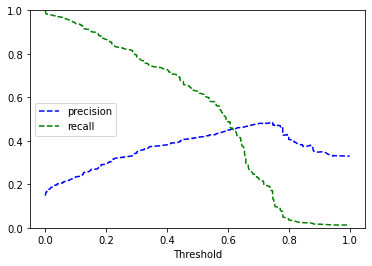

In [133]:
metrics_report(dec_tree_m3, X_train3, y_train3, X_test3, y_test3)

## Desempeño del Modelo por Canal

### Canal Dealers

----------------------------------------------------------------------------
CANAL DEALERS
----------------------------------------------------------------------------
Metrics Report Model DecisionTreeClassifier -- Training Dataset
---------------------------------------------------------------------------- 


 METRICS RESUME MODEL
Precision: 0.645052 
Recall: 0.726038 
F1: 0.683153
AUC:  0.696099829488412

 CONFUSION MATRIX


Verdadero  Falso
Verdadero      36505  18294
Falso          12545  33246

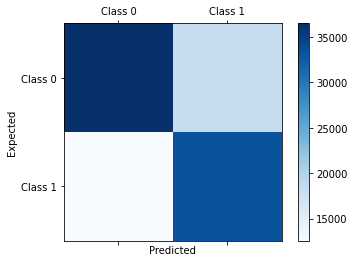


 METRICS MODEL


0             1  accuracy      macro avg   weighted avg
precision      0.744241      0.645052  0.693419       0.694646       0.699088
recall         0.666162      0.726038  0.693419       0.696100       0.693419
f1-score       0.703040      0.683153  0.693419       0.693097       0.693987
support    54799.000000  45791.000000  0.693419  100590.000000  100590.000000


 ROC CURVE MODEL


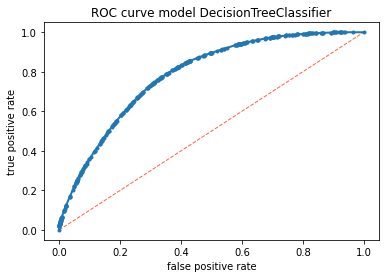


 PRECISION-RECALL CURVE


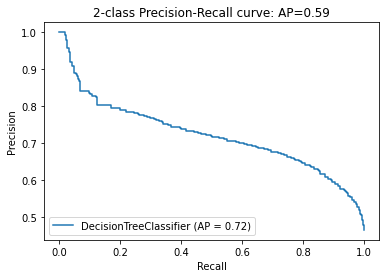


 TRADE-OFF PRECISION RECALL - TRAINING SET


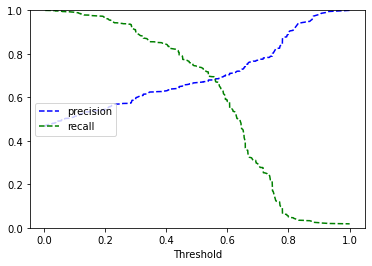


 
 ----------------------------------------------------------------------------
Metrics Report Model DecisionTreeClassifier -- Testing Dataset
---------------------------------------------------------------------------- 


 METRICS RESUME MODEL
Precision: 0.420635 
Recall: 0.713920 
F1: 0.529370
AUC:  0.6918000655347849

 CONFUSION MATRIX


Verdadero  Falso
Verdadero      38968  19221
Falso           5592  13955

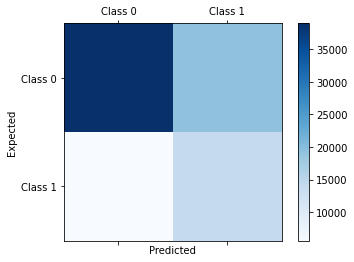


 METRICS MODEL


0             1  accuracy     macro avg  weighted avg
precision      0.874506      0.420635  0.680804      0.647571      0.760379
recall         0.669680      0.713920  0.680804      0.691800      0.680804
f1-score       0.758509      0.529370  0.680804      0.643940      0.700891
support    58189.000000  19547.000000  0.680804  77736.000000  77736.000000


 ROC CURVE MODEL


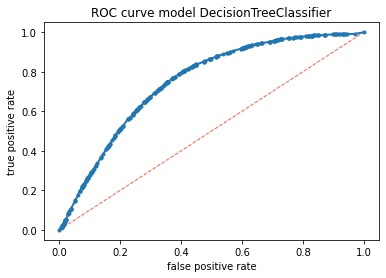


 PRECISION-RECALL CURVE


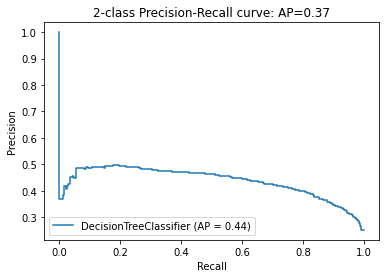


 TRADE-OFF PRECISION RECALL - TESTING SET


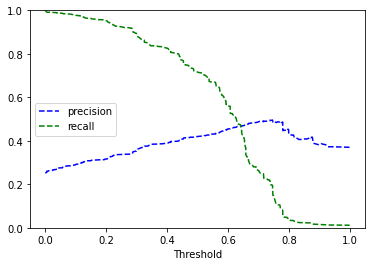

In [207]:
canal_report(dec_tree_m3, 1, X_train3, y_train3, X_test3, y_test3)

### Canal Directo

----------------------------------------------------------------------------
CANAL DEALERS
----------------------------------------------------------------------------
Metrics Report Model DecisionTreeClassifier -- Training Dataset
---------------------------------------------------------------------------- 


 METRICS RESUME MODEL
Precision: 0.645052 
Recall: 0.726038 
F1: 0.683153
AUC:  0.696099829488412

 CONFUSION MATRIX


Verdadero  Falso
Verdadero      36505  18294
Falso          12545  33246

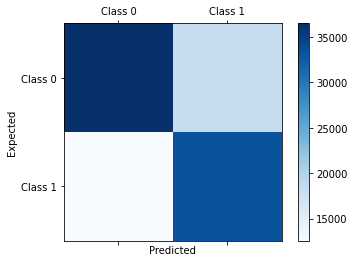


 METRICS MODEL


0             1  accuracy      macro avg   weighted avg
precision      0.744241      0.645052  0.693419       0.694646       0.699088
recall         0.666162      0.726038  0.693419       0.696100       0.693419
f1-score       0.703040      0.683153  0.693419       0.693097       0.693987
support    54799.000000  45791.000000  0.693419  100590.000000  100590.000000


 ROC CURVE MODEL


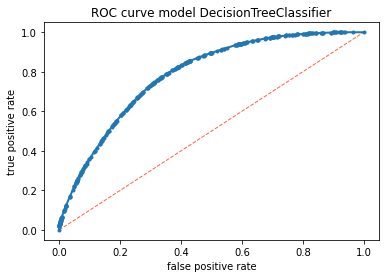


 PRECISION-RECALL CURVE


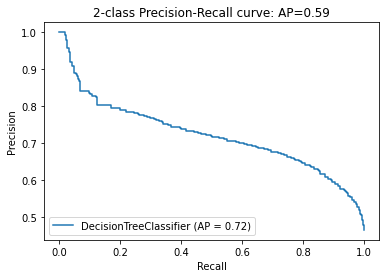


 TRADE-OFF PRECISION RECALL - TRAINING SET


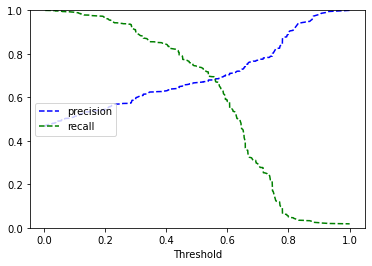


 
 ----------------------------------------------------------------------------
Metrics Report Model DecisionTreeClassifier -- Testing Dataset
---------------------------------------------------------------------------- 


 METRICS RESUME MODEL
Precision: 0.420635 
Recall: 0.713920 
F1: 0.529370
AUC:  0.6918000655347849

 CONFUSION MATRIX


Verdadero  Falso
Verdadero      38968  19221
Falso           5592  13955

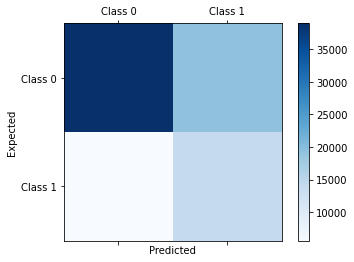


 METRICS MODEL


0             1  accuracy     macro avg  weighted avg
precision      0.874506      0.420635  0.680804      0.647571      0.760379
recall         0.669680      0.713920  0.680804      0.691800      0.680804
f1-score       0.758509      0.529370  0.680804      0.643940      0.700891
support    58189.000000  19547.000000  0.680804  77736.000000  77736.000000


 ROC CURVE MODEL


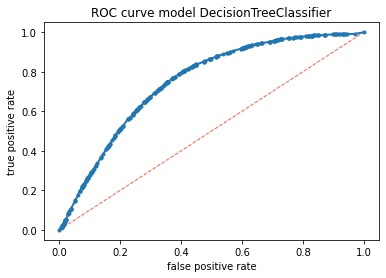


 PRECISION-RECALL CURVE


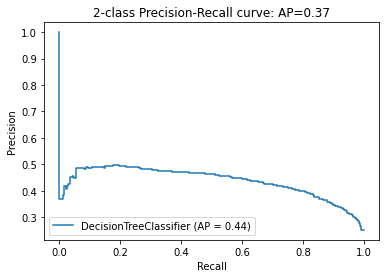


 TRADE-OFF PRECISION RECALL - TESTING SET


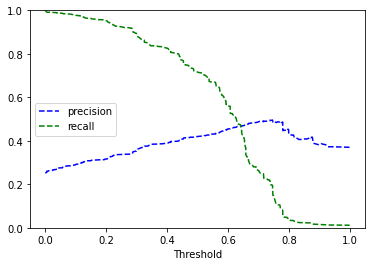

In [208]:
canal_report(dec_tree_m3, 1, X_train3, y_train3, X_test3, y_test3)

### Canal Masivos

----------------------------------------------------------------------------
CANAL DEALERS
----------------------------------------------------------------------------
Metrics Report Model DecisionTreeClassifier -- Training Dataset
---------------------------------------------------------------------------- 


 METRICS RESUME MODEL
Precision: 0.645052 
Recall: 0.726038 
F1: 0.683153
AUC:  0.696099829488412

 CONFUSION MATRIX


Verdadero  Falso
Verdadero      36505  18294
Falso          12545  33246

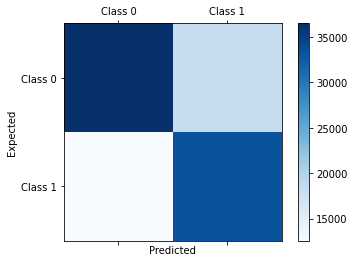


 METRICS MODEL


0             1  accuracy      macro avg   weighted avg
precision      0.744241      0.645052  0.693419       0.694646       0.699088
recall         0.666162      0.726038  0.693419       0.696100       0.693419
f1-score       0.703040      0.683153  0.693419       0.693097       0.693987
support    54799.000000  45791.000000  0.693419  100590.000000  100590.000000


 ROC CURVE MODEL


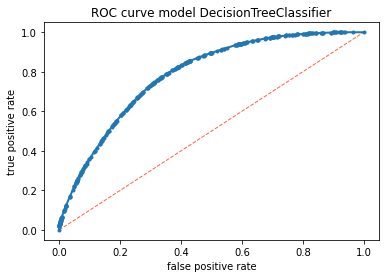


 PRECISION-RECALL CURVE


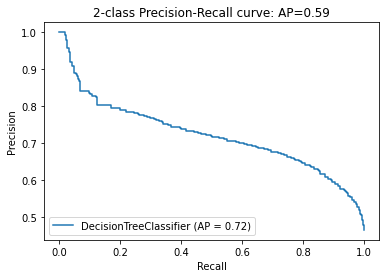


 TRADE-OFF PRECISION RECALL - TRAINING SET


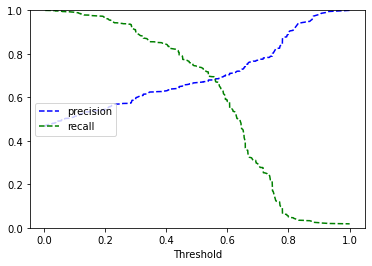


 
 ----------------------------------------------------------------------------
Metrics Report Model DecisionTreeClassifier -- Testing Dataset
---------------------------------------------------------------------------- 


 METRICS RESUME MODEL
Precision: 0.420635 
Recall: 0.713920 
F1: 0.529370
AUC:  0.6918000655347849

 CONFUSION MATRIX


Verdadero  Falso
Verdadero      38968  19221
Falso           5592  13955

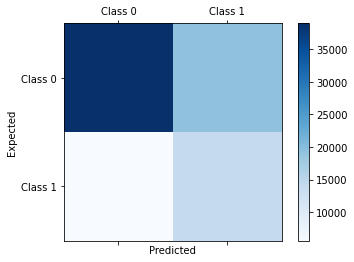


 METRICS MODEL


0             1  accuracy     macro avg  weighted avg
precision      0.874506      0.420635  0.680804      0.647571      0.760379
recall         0.669680      0.713920  0.680804      0.691800      0.680804
f1-score       0.758509      0.529370  0.680804      0.643940      0.700891
support    58189.000000  19547.000000  0.680804  77736.000000  77736.000000


 ROC CURVE MODEL


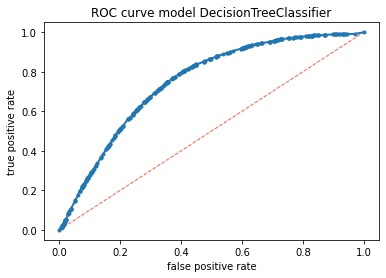


 PRECISION-RECALL CURVE


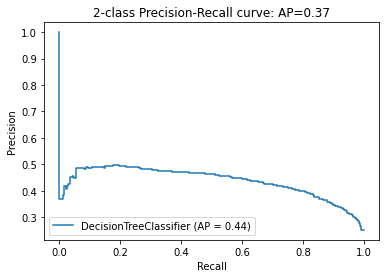


 TRADE-OFF PRECISION RECALL - TESTING SET


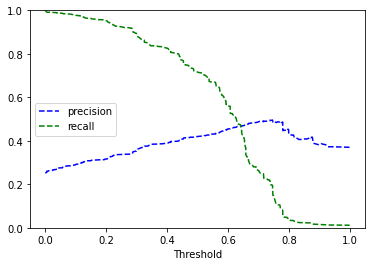

In [209]:
canal_report(dec_tree_m3, 1, X_train3, y_train3, X_test3, y_test3)

### Canal Corredor

----------------------------------------------------------------------------
CANAL DEALERS
----------------------------------------------------------------------------
Metrics Report Model DecisionTreeClassifier -- Training Dataset
---------------------------------------------------------------------------- 


 METRICS RESUME MODEL
Precision: 0.645052 
Recall: 0.726038 
F1: 0.683153
AUC:  0.696099829488412

 CONFUSION MATRIX


Verdadero  Falso
Verdadero      36505  18294
Falso          12545  33246

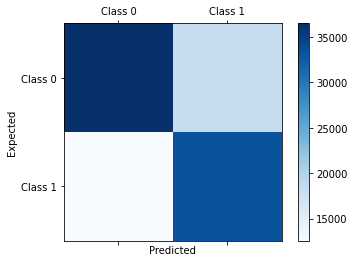


 METRICS MODEL


0             1  accuracy      macro avg   weighted avg
precision      0.744241      0.645052  0.693419       0.694646       0.699088
recall         0.666162      0.726038  0.693419       0.696100       0.693419
f1-score       0.703040      0.683153  0.693419       0.693097       0.693987
support    54799.000000  45791.000000  0.693419  100590.000000  100590.000000


 ROC CURVE MODEL


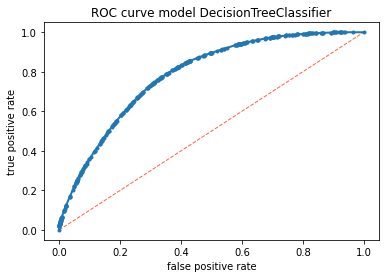


 PRECISION-RECALL CURVE


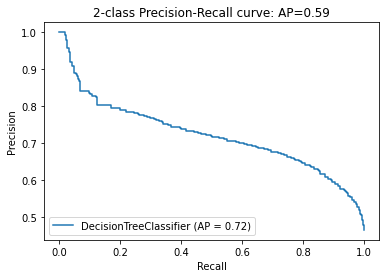


 TRADE-OFF PRECISION RECALL - TRAINING SET


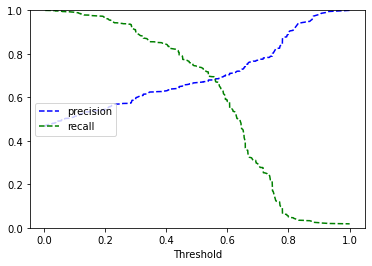


 
 ----------------------------------------------------------------------------
Metrics Report Model DecisionTreeClassifier -- Testing Dataset
---------------------------------------------------------------------------- 


 METRICS RESUME MODEL
Precision: 0.420635 
Recall: 0.713920 
F1: 0.529370
AUC:  0.6918000655347849

 CONFUSION MATRIX


Verdadero  Falso
Verdadero      38968  19221
Falso           5592  13955

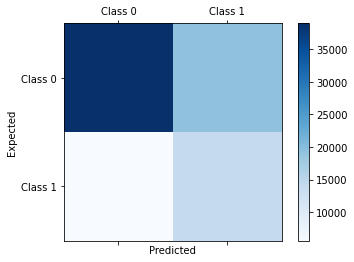


 METRICS MODEL


0             1  accuracy     macro avg  weighted avg
precision      0.874506      0.420635  0.680804      0.647571      0.760379
recall         0.669680      0.713920  0.680804      0.691800      0.680804
f1-score       0.758509      0.529370  0.680804      0.643940      0.700891
support    58189.000000  19547.000000  0.680804  77736.000000  77736.000000


 ROC CURVE MODEL


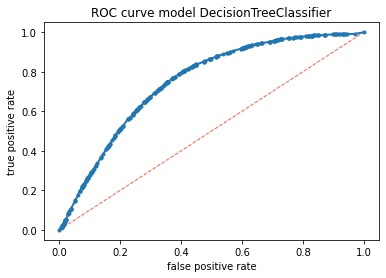


 PRECISION-RECALL CURVE


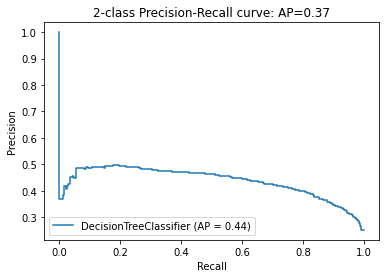


 TRADE-OFF PRECISION RECALL - TESTING SET


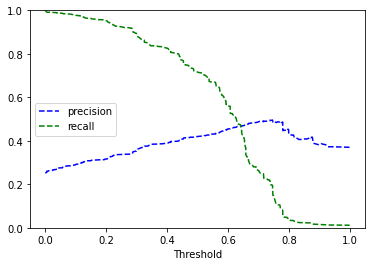

In [210]:
canal_report(dec_tree_m3, 1, X_train3, y_train3, X_test3, y_test3)

## Comparación de Desempeño por Canal 

### Comparación Train dataset

Metrics Comparison - Canales


DEALERS  DIRECTO  MASIVOS  CORREDOR
AUC        0.69610  0.59650  0.51242  0.531284
Accuracy   0.69342  0.81357  0.96274  0.899250
Presicion  0.69909  0.78157  0.94397  0.863580
Recall     0.69342  0.81357  0.96274  0.899250
F1         0.69399  0.78421  0.95252  0.878020

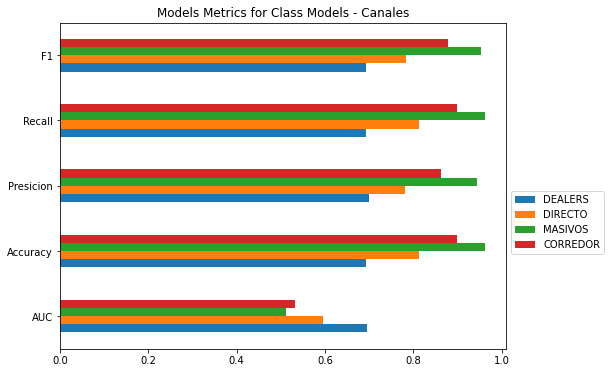

In [202]:
canal_comparison(dec_tree_m3, X_train3, y_train3)

### Comparación Test dataset

Metrics Comparison - Canales


DEALERS   DIRECTO   MASIVOS  CORREDOR
AUC        0.575697  0.532499  0.511189  0.517999
Accuracy   0.742550  0.899500  0.982660  0.950220
Presicion  0.704530  0.859670  0.974790  0.932450
Recall     0.742550  0.899500  0.982660  0.950220
F1         0.709990  0.873200  0.978550  0.940750

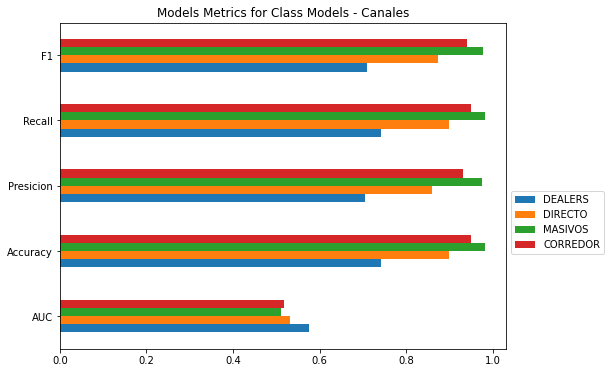

In [201]:
canal_comparison(dec_tree_m3, X_test3, y_test3)

# Comparación de desempeño por Modelo

## Comparación Train Dataset

Metrics Comparison


Model_DecisionTreeClassifier1  ...  Model_DecisionTreeClassifier3
AUC                             0.767742  ...                       0.740523
Accuracy                        0.767740  ...                       0.783660
Presicion                       0.768340  ...                       0.782840
Recall                          0.767740  ...                       0.783660
F1                              0.767610  ...                       0.783230

[5 rows x 3 columns]

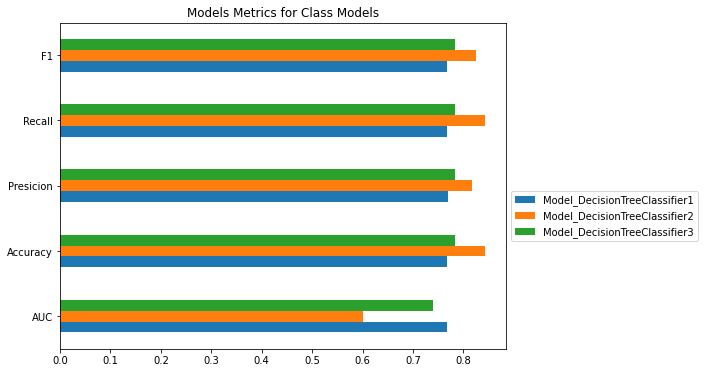

In [134]:
model_list = [dec_tree, dec_tree_m2, dec_tree_m3]
auc_list = [roc_auc_score(y_train, y_train_pred), roc_auc_score(y_train2, y_train_pred_m2), roc_auc_score(y_train3, y_train_pred_m3)]
metrics_list = [pd.DataFrame(classification_report(y_train, y_train_pred, output_dict = True)),
                pd.DataFrame(classification_report(y_train2, y_train_pred_m2, output_dict = True)),
                pd.DataFrame(classification_report(y_train3, y_train_pred_m3, output_dict = True))]
y_pred_list = [y_train_pred, y_train_pred_m2, y_train_pred_m3]
y_train_list = [y_train, y_train2, y_train3]


metrics_comparative(model_list, auc_list, metrics_list, y_train_list, y_pred_list)

## Comparación Dataset de Pruebas

Metrics Comparison


Model_DecisionTreeClassifier1  ...  Model_DecisionTreeClassifier3
AUC                             0.767319  ...                       0.736078
Accuracy                        0.746800  ...                       0.814620
Presicion                       0.864550  ...                       0.852770
Recall                          0.743340  ...                       0.814620
F1                              0.777930  ...                       0.829010

[5 rows x 3 columns]

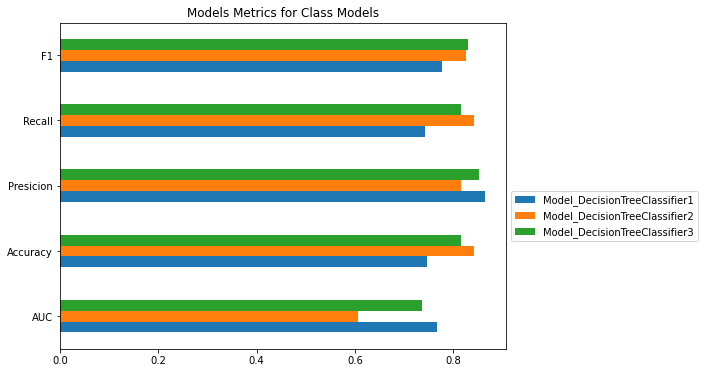

In [135]:
model_list = [dec_tree, dec_tree_m2, dec_tree_m3]
auc_list = [roc_auc_score(y_test, y_test_pred), 
            roc_auc_score(y_test2, y_test_pred_m2),
            roc_auc_score(y_test3, y_test_pred_m3)]
metrics_list = [pd.DataFrame(classification_report(y_test, y_test_pred, output_dict = True)),
                pd.DataFrame(classification_report(y_test2, y_test_pred_m2, output_dict = True)),
                pd.DataFrame(classification_report(y_test3, y_test_pred_m3, output_dict = True))]
y_pred_list = [y_test2, y_test_pred_m2, y_test_pred_m3]
y_train_list = [y_test, y_test2, y_test3]


metrics_comparative(model_list, auc_list, metrics_list, y_train_list, y_pred_list)

__COMENTARIOS__

- Todos los modelos consideran a la variable precot_modelo_id.
- El modelo 1 considera un balance perfecto (50-50) para ambas clases, las variables sisgen, edad y antiguedad de vehiculo han sido agrupadas.
- El modelo 2 considera las variables sin agrupar y la data no ha sido balanceada.
- El modelo 3 considera un desbalance ajustado (70-30) para ambas clases y datos agrupados.
- Todos los hyperparametros de los modelos han sido optimizados bajo F1 score.

# Validación del Modelo

In [ ]:
# Importando nuevos registros
uploaded = files.upload()

Saving Predicciones_prob_conversion.xlsx to Predicciones_prob_conversion.xlsx


In [ ]:
# file import to df
df_new = pd.read_excel('Predicciones_prob_conversion.xlsx', sheet_name='Dataset_predict').rename(columns={'canal_producto_code':'canal_code',
                                                                                                          'antigüedad' : 'antiguedad_veh'})

display(df_new.head())

dia_precot  prima_neta_deducible_anualizada  ...  antiguedad_veh  edad
0          25                            15.71  ...               0    34
1          25                            16.18  ...               0    34
2          25                            16.67  ...               0    34
3          25                            17.17  ...               0    34
4          25                            17.69  ...               0    34

[5 rows x 10 columns]

In [ ]:
# Normalizando campos del df importado a la estructura modelada
df_norm(df_new)
display(df_new.head())

dia_precot  ...  sisgen_bins_code
0          25  ...                 0
1          25  ...                 0
2          25  ...                 0
3          25  ...                 0
4          25  ...                 0

[5 rows x 10 columns]

In [ ]:
# Predicciones
y_new_predict = dec_tree.predict(df_new)
y_new_prob = dec_tree.predict_proba(df_new)

df_new = pd.concat([df_new, 
                    pd.Series(y_new_predict), 
                    pd.Series(y_new_prob[:,1])], 
                   axis=1).rename(columns={0 : 'Pred', 1 : 'Pred_Proba'})

In [ ]:
# Exportando df con predicciones a excel
df_new.to_excel("Predict_convert.xlsx",
                sheet_name='Predict') 

# Guardando excel exportado en drive - carpeta Proyecto_Nuevos_Clusters compartida
!cp /tmp/data_clusters/Predict_convert.xlsx /gdrive/My\ Drive/Proyecto_Nuevos_Clusters/Predict_convert.xlsx 

In [ ]:
display(df_new)

dia_precot  prima_neta_deducible_anualizada  ...  Pred  Pred_Proba
0           25                            15.71  ...     1    0.896435
1           25                            16.18  ...     1    0.896435
2           25                            16.67  ...     1    0.896435
3           25                            17.17  ...     1    0.862510
4           25                            17.69  ...     1    0.862510
5           25                            18.22  ...     1    0.862510
6           25                            18.77  ...     1    0.807184
7           25                            19.33  ...     1    0.807184
8           25                            19.91  ...     1    0.807184
9           25                            20.51  ...     1    0.807184
10          25                            21.13  ...     1    0.704931
11          25                            21.76  ...     1    0.704931
12          25                            22.41  ...     1    0.704931
13          25                            23.08  ...     1    0.543408
14          25                            23.77  ...     0    0.483544
15          25                            24.48  ...     0    0.397790
16          25                            25.21  ...     0    0.217054
17          25                            25.97  ...     0    0.217054
18          25                            26.75  ...     0    0.217054
19          25                            13.09  ...     0    0.263158
20          25                            13.48  ...     0    0.263158
21          25                            13.89  ...     0    0.263158
22          25                            14.31  ...     0    0.263158
23          25                            14.74  ...     0    0.263158
24          25                            15.18  ...     0    0.263158
25          25                            15.64  ...     0    0.263158
26          25                            16.11  ...     0    0.263158
27          25                            16.59  ...     0    0.263158
28          25                            17.09  ...     0    0.286738
29          25                            17.61  ...     0    0.286738
30          25                            18.13  ...     0    0.286738
31          25                            18.68  ...     0    0.286738
32          25                            19.23  ...     0    0.286738
33          25                            19.81  ...     0    0.286738
34          25                            20.40  ...     0    0.286738
35          25                            21.01  ...     0    0.286738
36          25                            21.64  ...     0    0.286738
37          25                            22.29  ...     0    0.286738

[38 rows x 12 columns]

----


# Tree Plot

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.479015 to fit



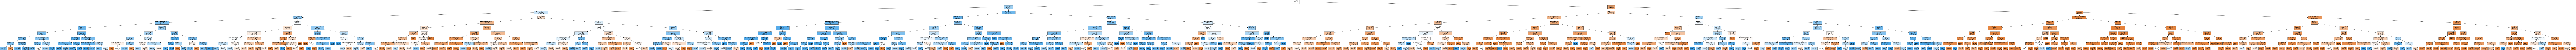

In [ ]:
# Plot Decision Tree
features = X_train.columns
tree_graph_to_png(dec_tree, features, png_file_to_save='decision_tree.png')
Image('decision_tree.png')   

# Propuesta: Optimizacion Bayesiana de Hyperparametros

In [ ]:
# Optimizacion Bayesiana de Hiperparametros
param_space = {
    'max_depth': hp.choice('max_depth', range(1,20)),
    'criterion': hp.choice('criterion', ["gini", "entropy"])}

best = 0
trials = Trials()

best = fmin(f, param_space, algo=tpe.suggest, max_evals=10, trials=trials)

print ('best:')
print (best)

In [ ]:
# Se entrena el Arbol con los parametros sugeridos por HyperOpt
tree_model = DecisionTreeClassifier(criterion= 'gini', 
                                    max_depth=7,
                                    random_state=1).fit(X = X_train, y = y_train)

#Desempeño del Nuevo Modelo (AUC)
metrics_report(tree_model, X_train, y_train, X_test, y_test)